## Import Libraries
The code used to implement the TD3 agent is taken from here: https://github.com/higgsfield/RL-Adventure-2.

In [1]:
import math
import random
import time
import pandas as pd

from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter 

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
use_cuda

False

## Save gifs of agent

In [2]:
def save_frames_as_gif(frames, path='./Visualizations/', filename='pendulum_gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='pillow', fps= 120)

## Create log(cosh) loss

In [3]:
def log_cosh(x):
    return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)

def log_cosh_loss(y_pred, y_true):
    return torch.mean(log_cosh(y_pred - y_true))

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        return log_cosh_loss(y_pred, y_true)
    
# class LogCoshLoss(torch.nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, y_t, y_prime_t):
#         ey_t = y_t - y_prime_t
#         return torch.mean(torch.log(torch.cosh(ey_t + 1e-12)))

## Replay Buffer

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        # Add space in buffer to add next tuple
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        # Add tuple to buffer
        self.buffer[self.position] = (state, action, reward, next_state, done)
        # Cycle index to beginning once buffer is full
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        # Creates a tuple of 5 elements: states, actions, ...., dones
        # Each element is an array of length = batch_size
        # i.e. first element is an array of states, second is an array of actions, etc
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

## Normalize action space

In [5]:
class NormalizedActions(gym.ActionWrapper):

    def action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)
        
        return action

    def reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = 2 * (action - low_bound) / (upper_bound - low_bound) - 1
        action = np.clip(action, low_bound, upper_bound)
        
        return action

## Gaussian Noise

In [6]:
class GaussianExploration(object):
    def __init__(self, action_space, max_sigma=1.0, min_sigma=1.0, decay_period=1000000):
        self.low  = action_space.low
        self.high = action_space.high
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
    
    def get_action(self, action, t=0):
        sigma  = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        action = action + np.random.normal(size=len(action)) * sigma
        # Output: array([action])
        return np.clip(action, self.low, self.high)

## Soft Update Function for Targets

In [7]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

## Define Actor and Critic Networks

In [8]:
# Critic
class ValueNetwork(nn.Module):
    def __init__(self, seed, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
    
# Actor
class PolicyNetwork(nn.Module):
    def __init__(self, seed, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(PolicyNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x
    
    def get_action(self, state):
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state)
        # [0] extracts [action] from array([[action]])
        return action.detach().cpu().numpy()[0]

## Plot Functions

In [9]:
def plot_rewards(rewards):
    plt.plot(range(len(rewards)), rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.show()
    plt.close()

def plot_smoothed(rewards, a):
    rewards_ema = pd.DataFrame(rewards).ewm(alpha = a).mean()
    plt.rcParams['figure.figsize'] = [10, 7]
    plt.plot(rewards_ema)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards (EMA)")
    plt.show()
    plt.close()

## Create Memorable Points Buffer

In [10]:
class Memory(dict):
    ''' 
    Memory is a nested dictionary
    keys are task indicators
    items are sorted dictionarys with keys that are hessian values and items that are memorable pts
    '''
    
    def __init__(self, capacity = 1000, n_tasks = None):
        super(Memory, self).__init__()
        self.capacity = capacity
        # Initialize sorted dictionary for each task
        if n_tasks is not None:
            for i in range(n_tasks):
                self[i + 1] = {}
            
    def add_task(self, task):
        self[task] = {}
                
    def add(self, task, key, items, minHess):
        cur_mem = self[task]
        # If memory not yet full
        if len(cur_mem) < self.capacity:
            # Add new memorable pt
            cur_mem[key.item()] = items
        else:
            # If given Hessian greater than min Hessian in memory
            if key > minHess:
                # Remove memorable pt with min Hessian
                cur_mem.pop(minHess)
                cur_mem[key.item()] = items
        # Return new min Hessian
        return min(cur_mem.keys())
            

## Create Regularizer and Hessian Function

In [11]:
def calc_reg(cur, mem_pts, prev, is_policy):
    '''
    Function to calculate regularizer term
    cur: current model f_t
    mem_pts: memorable points (nested dictionary)
    prev: previous model f_{t - 1}
    '''
    reg_term = 0
    n = len(mem_pts.keys())
    # Loop through all but current task
    for i in range(n - 1):
        cur_mem = mem_pts[i + 1]
        mem_states = torch.cat([obs[0] for obs in cur_mem.values()]).to(device)
        mem_actions = torch.cat([obs[1] for obs in cur_mem.values()]).to(device)
        if is_policy:
            f_t = cur(mem_states).detach()
            f_t_1 = prev(mem_states).detach()
        else:
            f_t = cur(mem_states, mem_actions).detach()
            f_t_1 = prev(mem_states, mem_actions).detach()
        reg_term += torch.sum((f_t - f_t_1)**2)
    return reg_term

def hessian(y):
    '''
    Function to calculate hessian: sech**2(y)
    y: loss tensor
    '''
    return 1 / torch.cosh(y)**2

## FROMP Update

In [12]:
# Note: mem_pts must be defined before calling this
def fromp_update(step,
           batch_size,
           replay_buffer,
           first_task,
           mem_pts,
           prev_Q = None,
           prev_policy = None,   
           sig = 1,
           gamma = 0.99,
           soft_tau=1e-2,
           noise_std = 0.2,
           noise_clip=0.5,
           policy_update=2,
          ):

    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    # Converts to tensor and adds extra dimension
    # i.e. tensor([[r_1], [r_2], ..., [r_n]])
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    # Converts dones to floats and does same conversion as rewards
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    # Select next action and add noise
    next_action = target_policy_net_fromp(next_state)
    noise = torch.normal(torch.zeros(next_action.size()), noise_std).to(device)
    noise = torch.clamp(noise, -noise_clip, noise_clip)
    next_action += noise

    # Calculate expected Q from target
    target_q_value1  = target_value_net_fromp1(next_state, next_action)
    target_q_value2  = target_value_net_fromp2(next_state, next_action)
    target_q_value   = torch.min(target_q_value1, target_q_value2)
    expected_q_value = reward + (1.0 - done) * gamma * target_q_value

    # Optimize critics
    q_value1 = value_net_fromp1(state, action)
    q_value2 = value_net_fromp2(state, action)
    
    value_loss1 = value_criterion(q_value1, expected_q_value.detach())
    value_loss2 = value_criterion(q_value2, expected_q_value.detach())
    
    # Calculate Hessians
    q_hess1, q_hess2 = hessian(value_loss1).detach(), hessian(value_loss2).detach()
    # Calculates row-wise max hessian (think of q_hess1 and q_hess2 as columns)
    max_hess = torch.max(q_hess1, q_hess2)
    # ID of current task
    # Note: memorable pts buffer must be already defined for current task
    # outside of update function
    task_id = len(mem_pts.keys())
    cur_mem = mem_pts[task_id]
    minHess = 0
    if len(cur_mem.keys()) > 0:
        minHess = min(cur_mem.keys())
    Qreg_term1, Qreg_term2 = 0, 0
    
    # Add observations to memorable pts buffer
    for i in range(batch_size):
        vals = (state[i].unsqueeze(0), action[i].unsqueeze(0))
        # Note: add() filters the observations for memorable pts
        new_minHess = mem_pts.add(task_id, max_hess, vals, minHess)    
        minHess = new_minHess
    
    if not first_task:        
        # Calculate regularization terms
        Qreg_term1 = calc_reg(value_net_fromp1, mem_pts, prev_Q, False)
        Qreg_term2 = calc_reg(value_net_fromp2, mem_pts, prev_Q, False)
#         print(sig * Qreg_term1, sig * Qreg_term2)
        
    # Update loss
    value_loss1 += sig * Qreg_term1
    value_loss2 += sig * Qreg_term2
    
    value_optimizer_fromp1.zero_grad()
    value_loss1.backward()
    value_optimizer_fromp1.step()

    value_optimizer_fromp2.zero_grad()
    value_loss2.backward()
    value_optimizer_fromp2.step()

    # Update target and optimize policy every policy_update steps
    if step % policy_update == 0:
        policy_reg_term = 0
        if not first_task:
            policy_reg_term = calc_reg(policy_net_fromp, mem_pts, prev_policy, True)
        policy_loss = value_net_fromp1(state, policy_net_fromp(state))
        policy_loss += sig * policy_reg_term
        policy_loss = -policy_loss.mean()

        policy_optimizer_fromp.zero_grad()
        policy_loss.backward()
        policy_optimizer_fromp.step()

        soft_update(value_net_fromp1, target_value_net_fromp1, soft_tau=soft_tau)
        soft_update(value_net_fromp2, target_value_net_fromp2, soft_tau=soft_tau)
        soft_update(policy_net_fromp, target_policy_net_fromp, soft_tau=soft_tau)

## Initialize Objects and Values

In [13]:
num_eps = 150
rewards = []
np.random.seed(24)
random.seed(24)
max_steps = 500
batch_size  = 128

earth = NormalizedActions(gym.make('Pendulum-v1', g = 9.81))
earth.reset(seed = 24)
# Initialize noise with action space information
noise = GaussianExploration(earth.action_space)

# state_dim  = earth.observation_space.shape[0] + 5
state_dim  = earth.observation_space.shape[0]
action_dim = earth.action_space.shape[0]
hidden_dim = 256
seed = 24

value_net_fromp1 = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
value_net_fromp2 = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
policy_net_fromp = PolicyNetwork(seed, state_dim, action_dim, hidden_dim).to(device)

target_value_net_fromp1 = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
target_value_net_fromp2 = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
target_policy_net_fromp = PolicyNetwork(seed, state_dim, action_dim, hidden_dim).to(device)

soft_update(value_net_fromp1, target_value_net_fromp1, soft_tau=1.0)
soft_update(value_net_fromp2, target_value_net_fromp2, soft_tau=1.0)
soft_update(policy_net_fromp, target_policy_net_fromp, soft_tau=1.0)
    
# value_criterion = nn.MSELoss()
value_criterion = LogCoshLoss()

policy_lr = 1e-3
value_lr  = 1e-3

value_optimizer_fromp1 = optim.Adam(value_net_fromp1.parameters(), lr=value_lr)
value_optimizer_fromp2 = optim.Adam(value_net_fromp2.parameters(), lr=value_lr)
policy_optimizer_fromp = optim.Adam(policy_net_fromp.parameters(), lr=policy_lr)

/Users/kenneth01px2018/gym/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


## Earth (FROMP)

Episode:  0
Episode:  100
Earth Complete


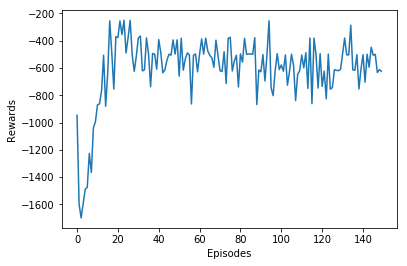

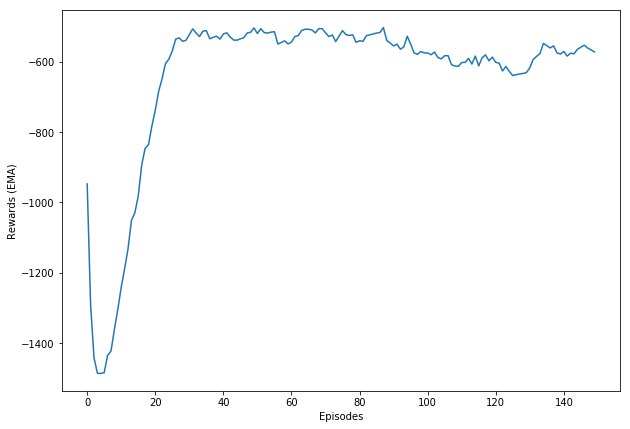

In [14]:
rewards_train_fromp = {}
rewards_test_fromp = {}
actions_earth = {}
rewards_train_fromp['earth1'] = []
mem_pts = Memory(capacity = 256, n_tasks = 1)


replay_buffer_size = 10000
replay_buffer_fromp = ReplayBuffer(replay_buffer_size)

for ep in range(num_eps):
    if ep % 100 == 0:
        print("Episode: ", ep)
    state = earth.reset()
    ep_reward = 0
    actions_earth[ep] = []
    for t in range(max_steps):
        action = policy_net_fromp.get_action(state)
        action = noise.get_action(action, t)
        next_state, reward, done, _ = earth.step(action)
        replay_buffer_fromp.push(state, action, reward, next_state, done)
        if len(replay_buffer_fromp) > batch_size:
            fromp_update(t, batch_size, replay_buffer_fromp, True, mem_pts)
        
        state = next_state
        ep_reward += reward
        actions_earth[ep].append(action)
        if done:
            break

    rewards_train_fromp['earth1'].append(ep_reward)
    
# Save models for next task
prev_Q = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_Q.load_state_dict(target_value_net_fromp1.state_dict())
prev_Q.eval()

prev_policy = PolicyNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_policy.load_state_dict(target_policy_net_fromp.state_dict())
prev_policy.eval()

print('Earth Complete')
rewards_earth1 = rewards_train_fromp['earth1']
plot_rewards(rewards_earth1)
plot_smoothed(rewards_earth1, 0.1)

/Users/kenneth01px2018/gym/gym/core.py:48: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "
/Users/kenneth01px2018/gym/gym/core.py:48: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


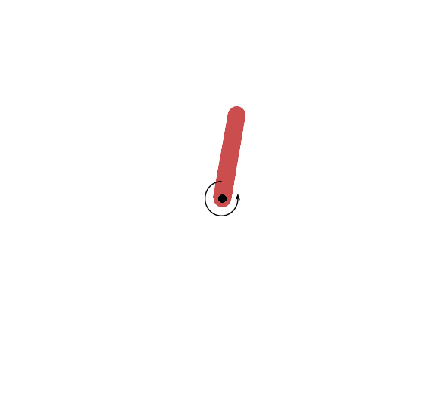

In [15]:
# Save video of earth agent
frames = []

for i in range(5):
#     if i == 0:
#         actions_earth[i] = []
#     earth.reset()
#     earth.state[:]= math.pi, 0
    state = earth.reset()
#     state = [np.cos(math.pi), np.sin(math.pi), 0.0]
    for t in range(max_steps):
        #Render to frames buffer
        frames.append(earth.render(mode="rgb_array"))
        time.sleep(0.001)
        action = policy_net_fromp.get_action(state)
        next_state, _, done, _ = earth.step(action)        
        state = next_state
#         if i == 0:
#             actions_earth[i].append(action[0])
        if done:
            break
earth.close()
save_frames_as_gif(frames, filename='earth_train_animation_fromp.gif')

## Moon (FROMP)

/Users/kenneth01px2018/gym/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


Episode:  0
Episode:  100
Moon Complete


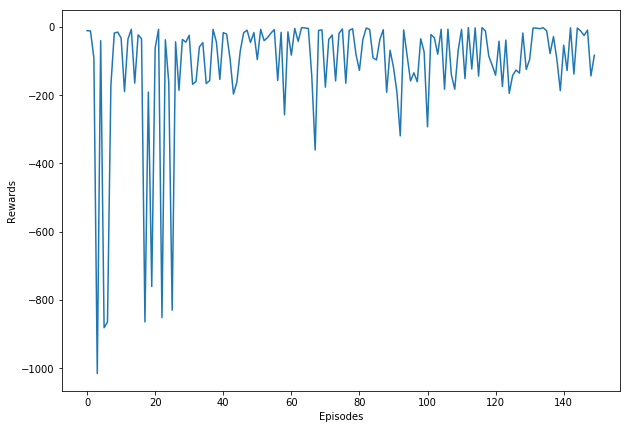

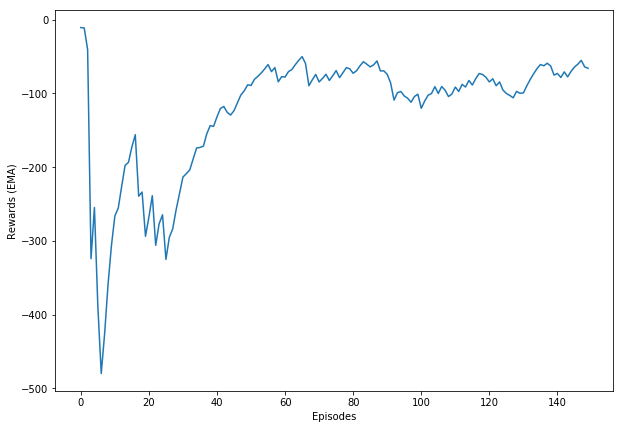

In [16]:
rewards_train_fromp['moon1'] = []
mem_pts.add_task(2)
actions_moon = {}

moon = NormalizedActions(gym.make('Pendulum-v1', g = 1.62))
moon.reset(seed = 24)

for ep in range(num_eps):
    if ep % 100 == 0:
        print("Episode: ", ep)
    state = moon.reset()
    ep_reward = 0
    actions_moon[ep] = []
    for t in range(max_steps):
        action = policy_net_fromp.get_action(state)
        action = noise.get_action(action, t)
        next_state, reward, done, _ = moon.step(action)
        replay_buffer_fromp.push(state, action, reward, next_state, done)
        if len(replay_buffer_fromp) > batch_size:
            fromp_update(t, batch_size, replay_buffer_fromp, False, mem_pts, prev_Q, prev_policy)
        
        state = next_state
        ep_reward += reward
        actions_moon[ep].append(action)
        
        if done:
            break

    rewards_train_fromp['moon1'].append(ep_reward)
    
# Save models for next task
prev_Q = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_Q.load_state_dict(target_value_net_fromp1.state_dict())
prev_Q.eval()

prev_policy = PolicyNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_policy.load_state_dict(target_policy_net_fromp.state_dict())
prev_policy.eval()

print('Moon Complete')
rewards_moon1 = rewards_train_fromp['moon1']
plot_rewards(rewards_moon1)
plot_smoothed(rewards_moon1, 0.1)

/Users/kenneth01px2018/gym/gym/core.py:48: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


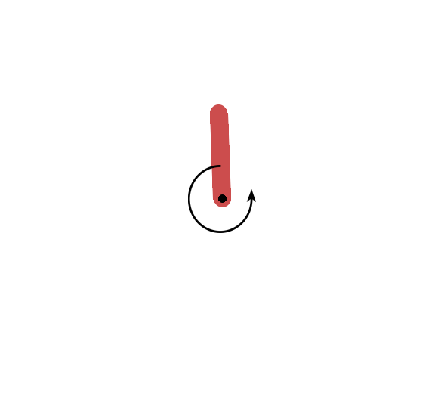

In [17]:
# Save video of moon agent
frames = []
for i in range(5):
#     if i == 0:
#         actions_moon[i] = []
    moon.reset()
#     moon.state[:]= math.pi, 0
#     state = [np.cos(math.pi), np.sin(math.pi), 0.0]
    for t in range(max_steps):
        #Render to frames buffer
        frames.append(moon.render(mode="rgb_array"))
        time.sleep(0.001)
        action = policy_net_fromp.get_action(state)
        next_state, _, done, _ = moon.step(action)        
        state = next_state
#         if i == 0:
#             actions_moon[i].append(action[0])
        if done:
            break
moon.close()
save_frames_as_gif(frames, filename='moon_train_animation_fromp.gif')

## Mars (FROMP)

/Users/kenneth01px2018/gym/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


Episode:  0
Episode:  100
Mars Complete


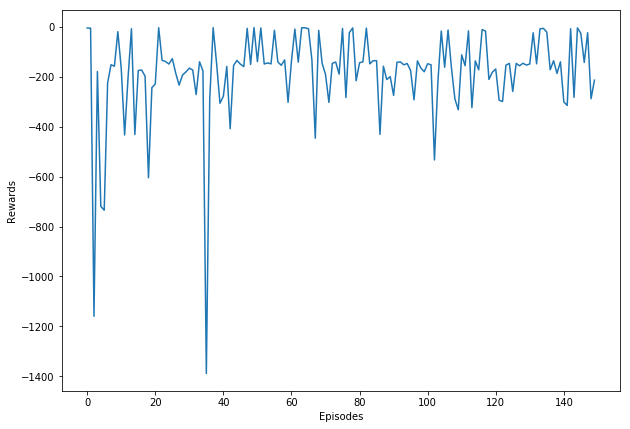

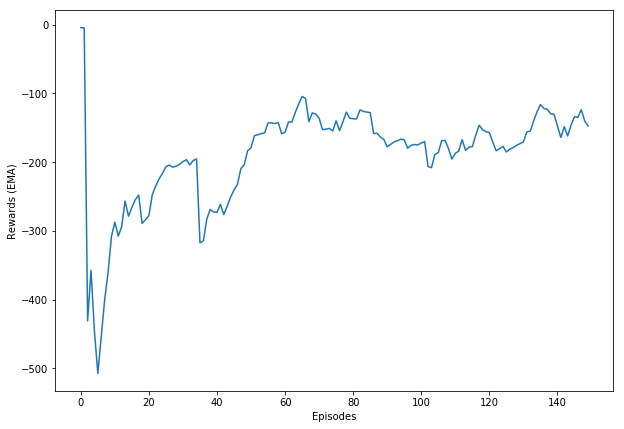

In [18]:
rewards_train_fromp['mars1'] = []
mem_pts.add_task(3)
actions_mars = {}

mars = NormalizedActions(gym.make('Pendulum-v1', g = 3.71))
mars.reset(seed = 24)

for ep in range(num_eps):
    if ep % 100 == 0:
        print("Episode: ", ep)
    state = mars.reset()
    actions_mars[ep] = []
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net_fromp.get_action(state)
        action = noise.get_action(action, t)
        next_state, reward, done, _ = mars.step(action)
        replay_buffer_fromp.push(state, action, reward, next_state, done)
        if len(replay_buffer_fromp) > batch_size:
            fromp_update(t, batch_size, replay_buffer_fromp, False, mem_pts, prev_Q, prev_policy)
        
        state = next_state
        ep_reward += reward
        actions_mars[ep].append(action)
        
        if done:
            break

    rewards_train_fromp['mars1'].append(ep_reward)
    
# Save models for next task
prev_Q = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_Q.load_state_dict(target_value_net_fromp1.state_dict())
prev_Q.eval()

prev_policy = PolicyNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_policy.load_state_dict(target_policy_net_fromp.state_dict())
prev_policy.eval()

print('Mars Complete')
rewards_mars1 = rewards_train_fromp['mars1']
plot_rewards(rewards_mars1)
plot_smoothed(rewards_mars1, 0.1)

/Users/kenneth01px2018/gym/gym/core.py:48: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


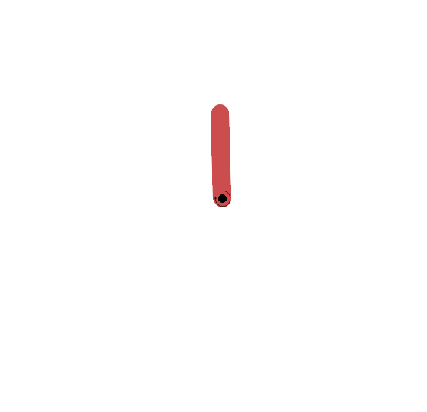

In [19]:
# Save video of mars agent
frames = []
for i in range(5):
#     if i == 0:
#         actions_mars[i] = []
    mars.reset()
#     mars.state[:]= math.pi, 0
#     state = [np.cos(math.pi), np.sin(math.pi), 0.0]
    for t in range(max_steps):
        #Render to frames buffer
        frames.append(mars.render(mode="rgb_array"))
        time.sleep(0.001)
        action = policy_net_fromp.get_action(state)
        next_state, _, done, _ = mars.step(action)        
        state = next_state
#         if i == 0:
#             actions_mars[i].append(action[0])
        if done:
            break
mars.close()
save_frames_as_gif(frames, filename='mars_train_animation_fromp.gif')

## Sun (FROMP)

/Users/kenneth01px2018/gym/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


Episode:  0
Episode:  100
Sun Complete


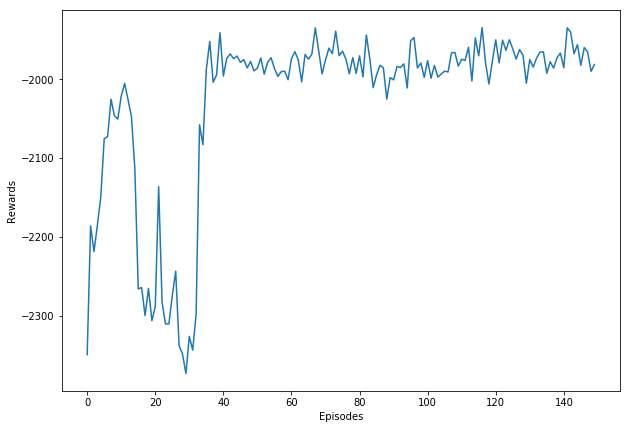

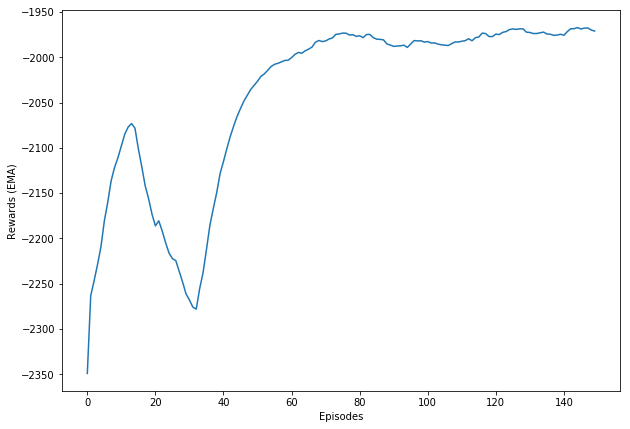

In [20]:
rewards_train_fromp['sun1'] = []
mem_pts.add_task(4)

sun = NormalizedActions(gym.make('Pendulum-v1', g = 275))
sun.reset(seed = 24)

for ep in range(num_eps):
    if ep % 100 == 0:
        print("Episode: ", ep)
    state = sun.reset()
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net_fromp.get_action(state)
        action = noise.get_action(action, t)
        next_state, reward, done, _ = sun.step(action)
        replay_buffer_fromp.push(state, action, reward, next_state, done)
        if len(replay_buffer_fromp) > batch_size:
            fromp_update(t, batch_size, replay_buffer_fromp, False, mem_pts, prev_Q, prev_policy)
        
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_train_fromp['sun1'].append(ep_reward)
    
# Save models for next task
prev_Q = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_Q.load_state_dict(target_value_net_fromp1.state_dict())
prev_Q.eval()

prev_policy = PolicyNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_policy.load_state_dict(target_policy_net_fromp.state_dict())
prev_policy.eval()

print('Sun Complete')
rewards_sun1 = rewards_train_fromp['sun1']
plot_rewards(rewards_sun1)
plot_smoothed(rewards_sun1, 0.1)

In [21]:
# # Save video of sun agent
# frames = []
# for _ in range(5):
#     state = sun.reset()
#     for t in range(max_steps):
#         #Render to frames buffer
#         frames.append(sun.render(mode="rgb_array"))
#         time.sleep(0.001)
#         action = policy_net_fromp.get_action(state)
#         next_state, _, done, _ = sun.step(action)        
#         state = next_state
#         if done:
#             break
# sun.close()
# save_frames_as_gif(frames, filename='sun_train_animation_fromp.gif')

## Jupiter (FROMP)

Episode:  0
Episode:  100
Jupiter Complete


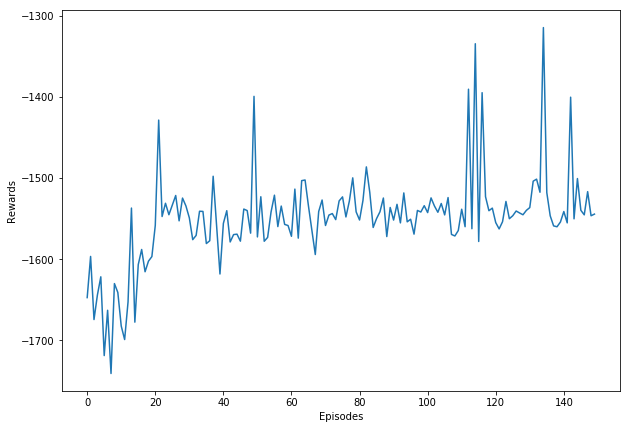

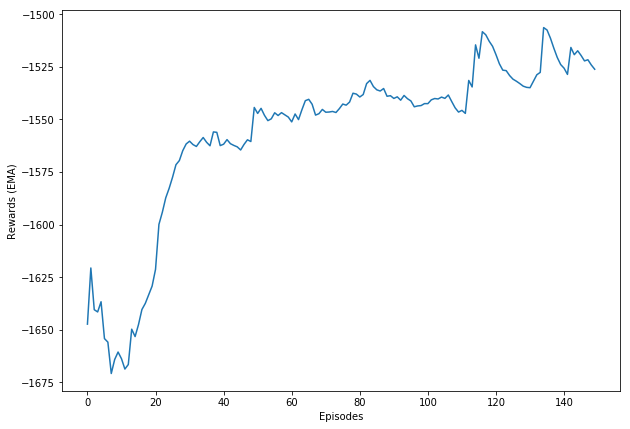

In [22]:
rewards_train_fromp['jupiter1'] = []
mem_pts.add_task(5)

jupiter = NormalizedActions(gym.make('Pendulum-v1', g = 24.5))
jupiter.reset(seed = 24)

for ep in range(num_eps):
    if ep % 100 == 0:
        print("Episode: ", ep)
    state = jupiter.reset()
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net_fromp.get_action(state)
        action = noise.get_action(action, t)
        next_state, reward, done, _ = jupiter.step(action)
        replay_buffer_fromp.push(state, action, reward, next_state, done)
        if len(replay_buffer_fromp) > batch_size:
            fromp_update(t, batch_size, replay_buffer_fromp, False, mem_pts, prev_Q, prev_policy)
        
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_train_fromp['jupiter1'].append(ep_reward)
    
# Save models for next task
prev_Q = ValueNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_Q.load_state_dict(target_value_net_fromp1.state_dict())
prev_Q.eval()

prev_policy = PolicyNetwork(seed, state_dim, action_dim, hidden_dim).to(device)
prev_policy.load_state_dict(target_policy_net_fromp.state_dict())
prev_policy.eval()

print('Jupiter Complete')
rewards_jupiter1 = rewards_train_fromp['jupiter1']
plot_rewards(rewards_jupiter1)
plot_smoothed(rewards_jupiter1, 0.1)

In [23]:
# # Save video of jupiter agent
# frames = []
# for _ in range(5):
#     state = jupiter.reset()
#     for t in range(max_steps):
#         #Render to frames buffer
#         frames.append(jupiter.render(mode="rgb_array"))
#         time.sleep(0.001)
#         action = policy_net_fromp.get_action(state)
#         next_state, _, done, _ = jupiter.step(action)        
#         state = next_state
#         if done:
#             break
# jupiter.close()
# save_frames_as_gif(frames, filename='jupiter_train_animation_fromp.gif')

## Save and Plot Results

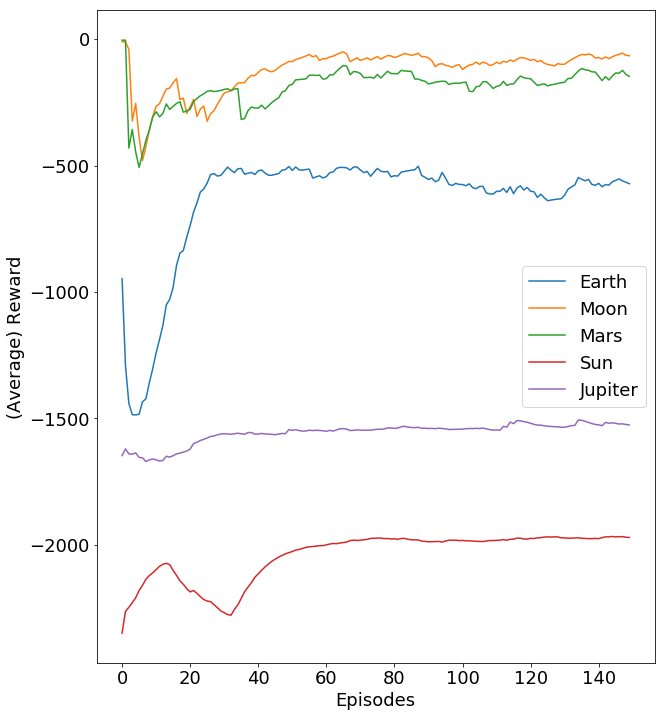

In [24]:
plt.rcParams.update({'font.size': 18}) 
train_df_fromp = pd.DataFrame(rewards_train_fromp)
train_df_fromp.to_csv('./Data/train_rewards_pendulum_fromp.csv')
figure, axis = plt.subplots(1, 1)

axis.plot(train_df_fromp.ewm(alpha = 0.1).mean())
axis.set_xlabel("Episodes")
axis.set_ylabel("(Average) Reward")
axis.legend(['Earth', "Moon", "Mars", "Sun", "Jupiter"])
# axis.set_ylim(-1100, 0)
fig = plt.gcf()
fig.set_size_inches(10, 12)
plt.savefig("./Visualizations/train_no_CL_fromp.jpg")
plt.show()

## Earth (test)

Earth Complete


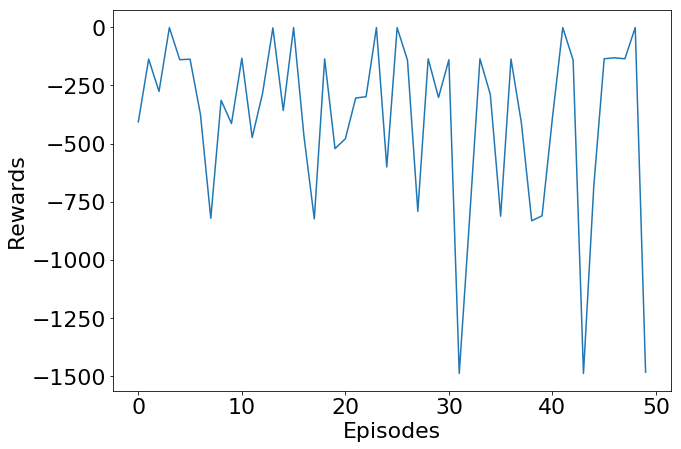

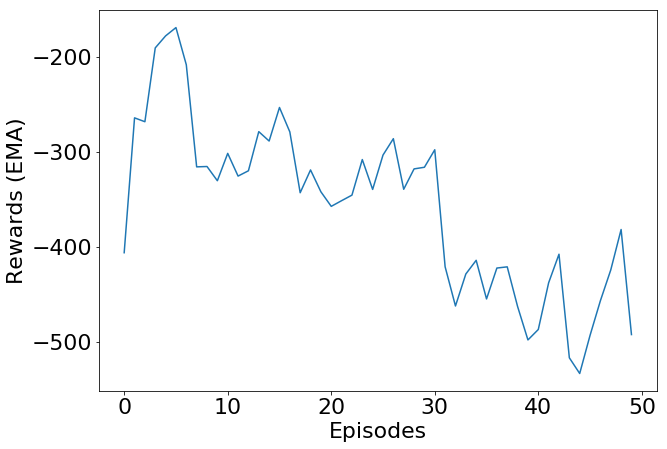

In [60]:
rewards_test_fromp['earth'] = []
test_eps = 50
actions_earth_test = {}
thetas = []
theta_dt = []
actions = []

for ep in range(test_eps):
    state = earth.reset()
    actions_earth_test[ep] = []
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net_fromp.get_action(state)
        thetas.append(np.arcsin(state[1]))
        theta_dt.append(state[2])
        actions.append(action[0])
        next_state, reward, done, _ = earth.step(action)
        state = next_state
        ep_reward += reward
        actions_earth_test[ep].append(action)
        
        if done:
            break

    rewards_test_fromp['earth'].append(ep_reward)

print('Earth Complete')
rewards_earth = rewards_test_fromp['earth']
plot_rewards(rewards_earth)
plot_smoothed(rewards_earth, 0.1)

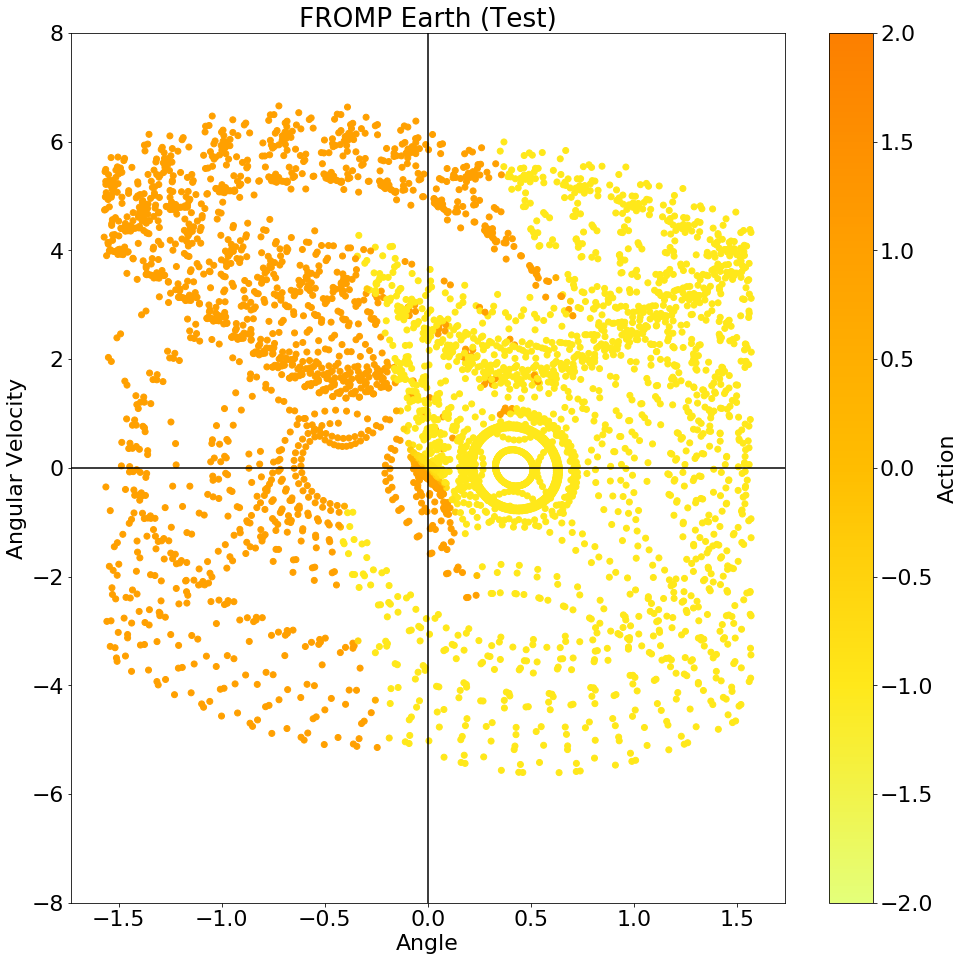

In [61]:
plt.scatter(thetas, theta_dt, c = actions, cmap = plt.get_cmap('Wistia'), vmin = -2, vmax = 2)
plt.colorbar(label = 'Action')
plt.title("FROMP Earth (Test)")
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlabel("Angle")
plt.ylabel("Angular Velocity")
plt.ylim(-8, 8)
fig = plt.gcf()
fig.set_size_inches(16, 16)
plt.savefig("./Visualizations/earth_test_policy_fromp.jpg")
plt.show()

/Users/kenneth01px2018/gym/gym/core.py:48: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


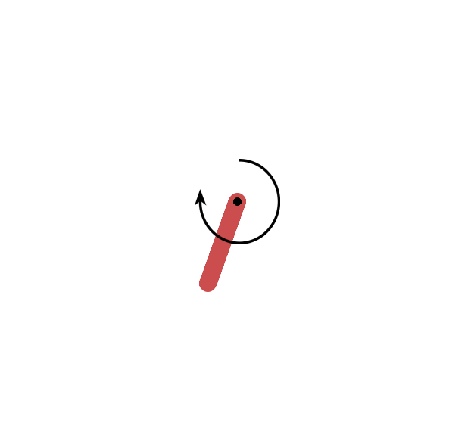

In [28]:
# Save video of earth agent
frames = []
for i in range(5):
    earth.reset()
#     earth.state[:]= math.pi, 0
#     state = [np.cos(math.pi), np.sin(math.pi), 0.0]
#     if i == 0:
#         actions_earth_test[i] = []
    for t in range(max_steps):
        #Render to frames buffer
        frames.append(earth.render(mode="rgb_array"))
        time.sleep(0.001)
        action = policy_net_fromp.get_action(state)
        next_state, _, done, _ = earth.step(action)        
        state = next_state
#         if i == 0:
#             actions_earth_test[i].append(action[0])
        if done:
            break
earth.close()
save_frames_as_gif(frames, filename='earth_test_animation_fromp.gif')

## Moon (test)

Moon Complete


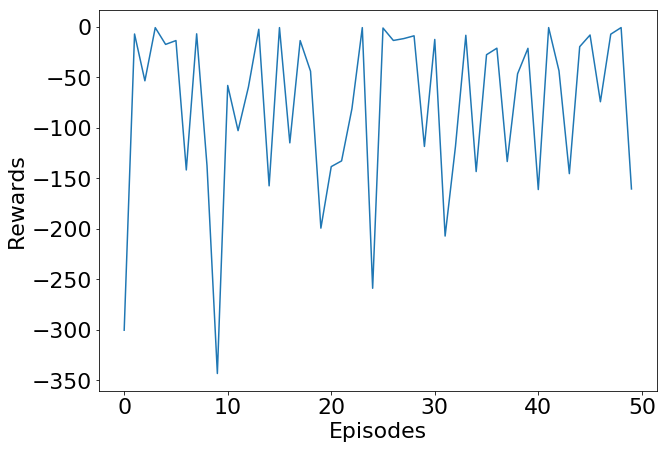

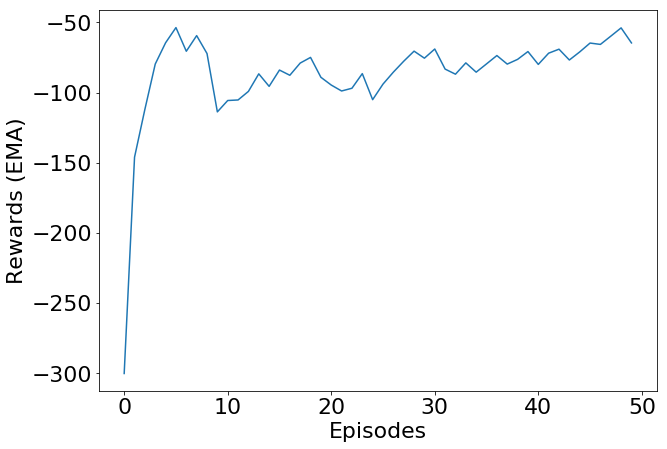

In [57]:
rewards_test_fromp['moon'] = []
actions_moon_test = {}
thetas = []
theta_dt = []
actions = []

for ep in range(test_eps):
    state = moon.reset()
    actions_moon_test[ep] = []
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net_fromp.get_action(state)
        next_state, reward, done, _ = moon.step(action)
        thetas.append(np.arcsin(state[1]))
        theta_dt.append(state[2])
        actions.append(action[0])
        state = next_state
        ep_reward += reward
        actions_moon_test[ep].append(action)
        
        if done:
            break

    rewards_test_fromp['moon'].append(ep_reward)

print('Moon Complete')
rewards_moon = rewards_test_fromp['moon']
plot_rewards(rewards_moon)
plot_smoothed(rewards_moon, 0.1)

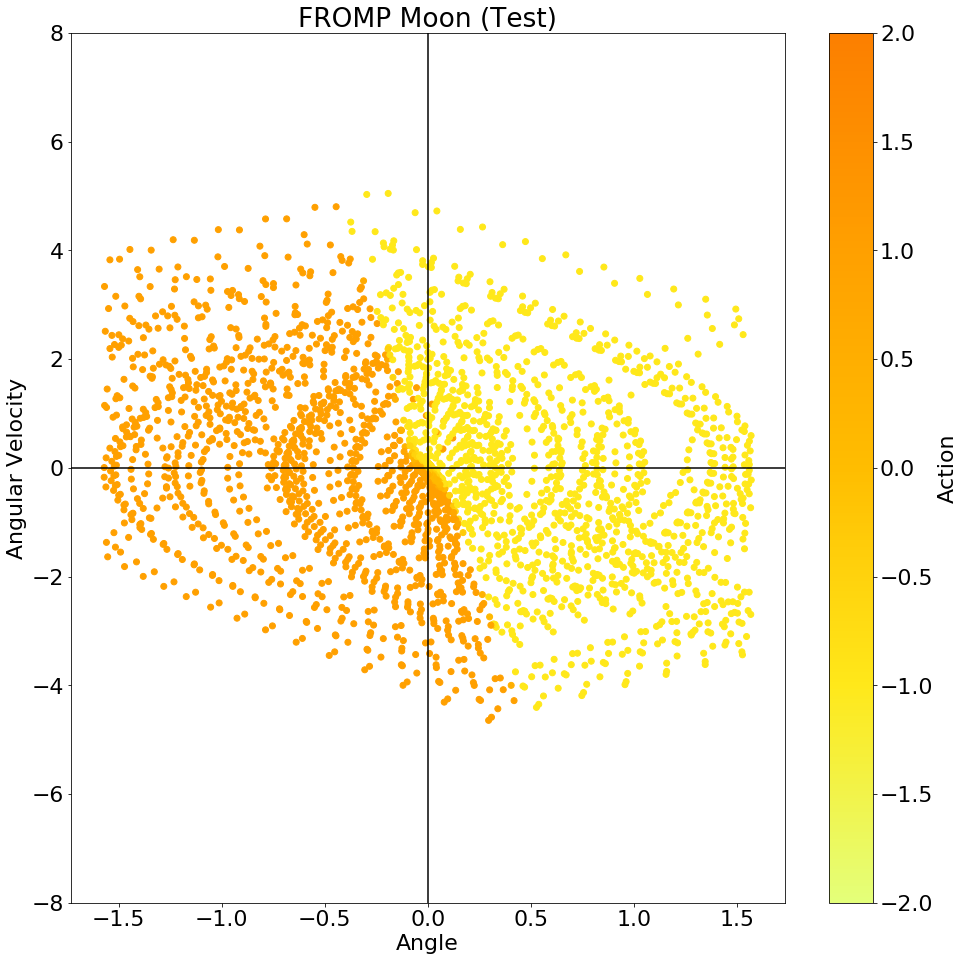

In [58]:
plt.scatter(thetas, theta_dt, c = actions, cmap = plt.get_cmap('Wistia'), vmin = -2, vmax = 2)
plt.colorbar(label = 'Action')
plt.title("FROMP Moon (Test)")
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlabel("Angle")
plt.ylabel("Angular Velocity")
plt.ylim(-8, 8)
fig = plt.gcf()
fig.set_size_inches(16, 16)
plt.savefig("./Visualizations/moon_test_policy_fromp.jpg")
plt.show()

/Users/kenneth01px2018/gym/gym/core.py:48: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


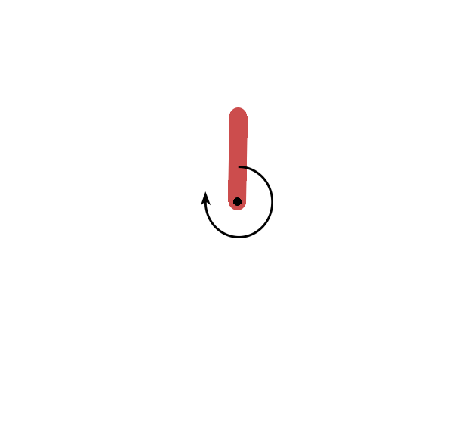

In [31]:
# Save video of moon agent
frames = []
for i in range(5):
#     if i == 0:
#         actions_moon_test[i] = []
    moon.reset()
#     moon.state[:]= math.pi, 0
#     state = [np.cos(math.pi), np.sin(math.pi), 0.0]    
    for t in range(max_steps):
        #Render to frames buffer
        frames.append(moon.render(mode="rgb_array"))
        time.sleep(0.001)
        action = policy_net_fromp.get_action(state)
        next_state, _, done, _ = moon.step(action)        
        state = next_state
#         if i == 0:
#             actions_moon_test[i].append(action[0])
        if done:
            break
moon.close()
save_frames_as_gif(frames, filename='moon_test_animation_fromp.gif')

## Mars (test)

Mars Complete


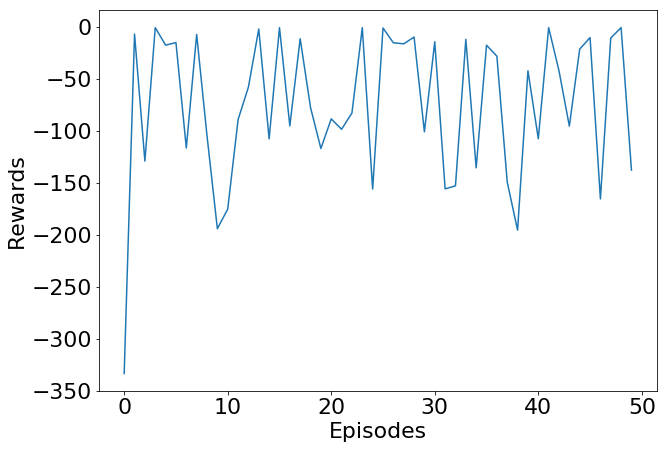

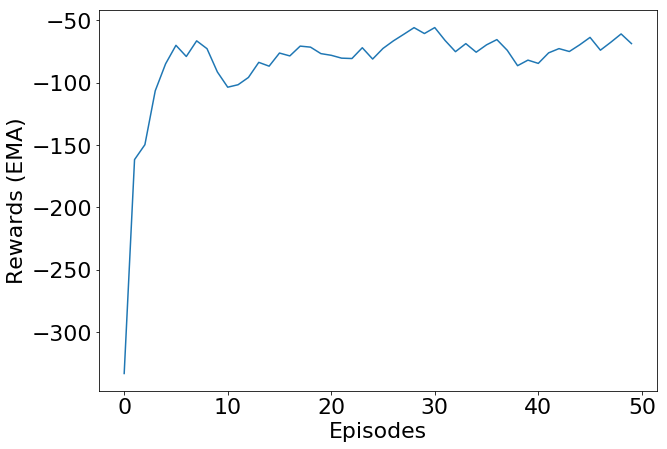

In [54]:
rewards_test_fromp['mars'] = []
actions_mars_test = {}
thetas = []
theta_dt = []
actions = []

for ep in range(test_eps):
    state = mars.reset()
    ep_reward = 0
    actions_mars_test[ep] = []
    for t in range(max_steps):
        action = policy_net_fromp.get_action(state)
        next_state, reward, done, _ = mars.step(action)
        thetas.append(np.arcsin(state[1]))
        theta_dt.append(state[2])
        actions.append(action[0])
        state = next_state
        ep_reward += reward
        actions_mars_test[ep].append(action)
        
        if done:
            break

    rewards_test_fromp['mars'].append(ep_reward)

print('Mars Complete')
rewards_mars = rewards_test_fromp['mars']
plot_rewards(rewards_mars)
plot_smoothed(rewards_mars, 0.1)

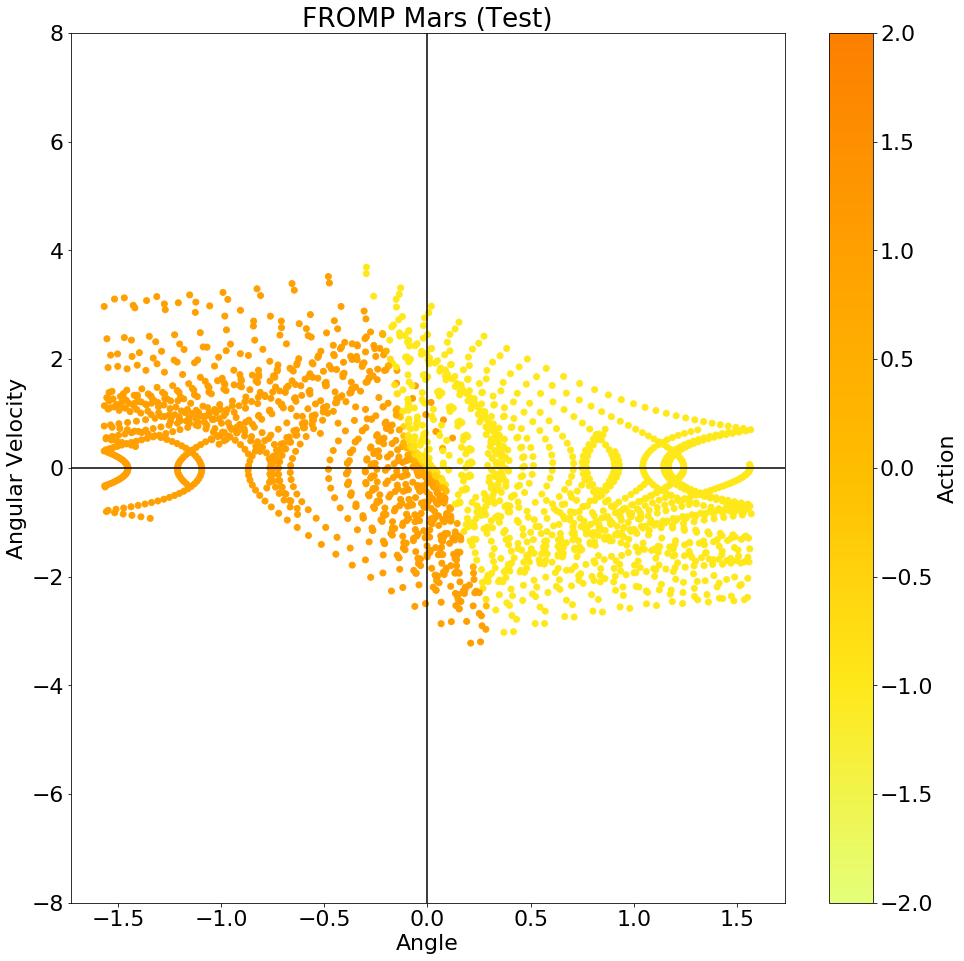

In [56]:
plt.scatter(thetas, theta_dt, c = actions, cmap = plt.get_cmap('Wistia'), vmin = -2, vmax = 2)
plt.colorbar(label = 'Action')
plt.title("FROMP Mars (Test)")
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlabel("Angle")
plt.ylabel("Angular Velocity")
plt.ylim(-8, 8)
fig = plt.gcf()
fig.set_size_inches(16, 16)
plt.savefig("./Visualizations/mars_test_policy_fromp.jpg")
plt.show()

/Users/kenneth01px2018/gym/gym/core.py:48: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


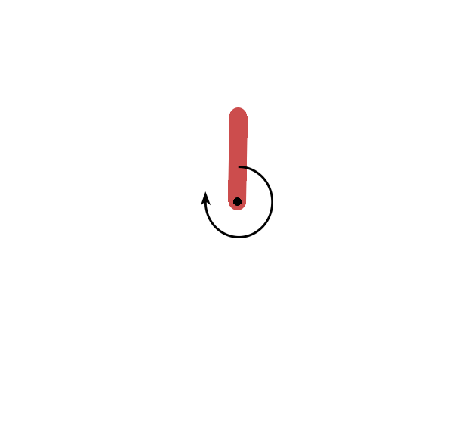

In [34]:
# Save video of mars agent
frames = []
for i in range(5):
#     if i == 0:
#         actions_mars_test[i] = []
    mars.reset()
#     mars.state[:]= math.pi, 0
#     state = [np.cos(math.pi), np.sin(math.pi), 0.0] 
    for t in range(max_steps):
        #Render to frames buffer
        frames.append(mars.render(mode="rgb_array"))
        time.sleep(0.001)
        action = policy_net_fromp.get_action(state)
        next_state, _, done, _ = mars.step(action)        
        state = next_state
#         if i == 0:
#             actions_mars_test[i].append(action[0])
        if done:
            break
mars.close()
save_frames_as_gif(frames, filename='mars_test_animation_fromp.gif')

## Sun (test)

Sun Complete


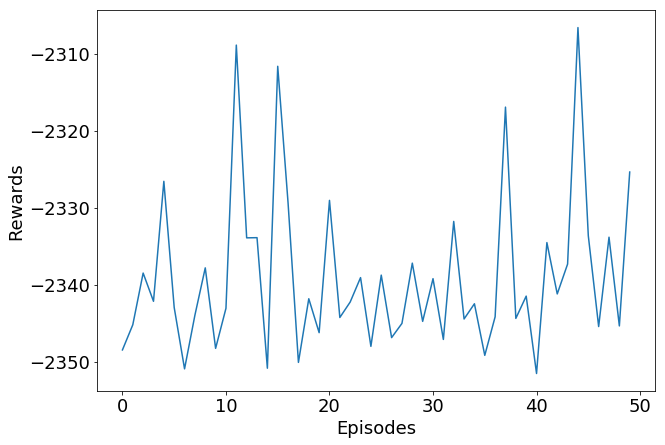

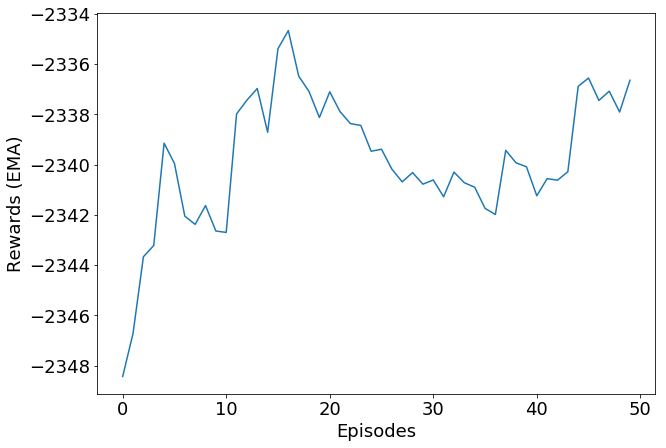

In [35]:
rewards_test_fromp['sun'] = []

for ep in range(test_eps):
    state = sun.reset()
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net_fromp.get_action(state)
        next_state, reward, done, _ = sun.step(action)
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_test_fromp['sun'].append(ep_reward)

print('Sun Complete')
rewards_sun = rewards_test_fromp['sun']
plot_rewards(rewards_sun)
plot_smoothed(rewards_sun, 0.1)

In [36]:
# # Save video of sun agent
# frames = []
# for _ in range(5):
#     state = sun.reset()
#     for t in range(max_steps):
#         #Render to frames buffer
#         frames.append(sun.render(mode="rgb_array"))
#         time.sleep(0.001)
#         action = policy_net_fromp.get_action(state)
#         next_state, _, done, _ = sun.step(action)        
#         state = next_state
#         if done:
#             break
# sun.close()
# save_frames_as_gif(frames, filename='sun_test_animation_fromp.gif')

## Jupiter (test)

Jupiter Complete


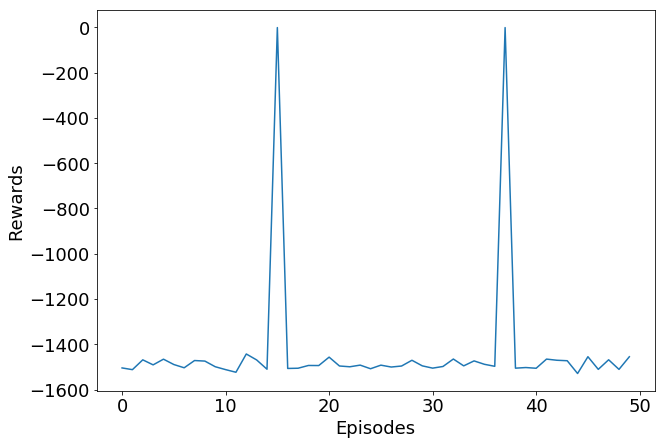

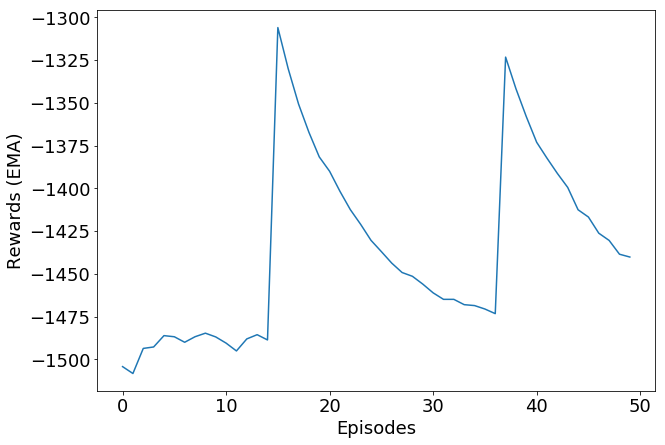

In [37]:
rewards_test_fromp['jupiter'] = []

for ep in range(test_eps):
    state = jupiter.reset()
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net_fromp.get_action(state)
        next_state, reward, done, _ = jupiter.step(action)
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_test_fromp['jupiter'].append(ep_reward)

print('Jupiter Complete')
rewards_jupiter = rewards_test_fromp['jupiter']
plot_rewards(rewards_jupiter)
plot_smoothed(rewards_jupiter, 0.1)

In [38]:
# # Save video of jupiter agent
# frames = []
# for _ in range(5):
#     state = jupiter.reset()
#     for t in range(max_steps):
#         #Render to frames buffer
#         frames.append(jupiter.render(mode="rgb_array"))
#         time.sleep(0.001)
#         action = policy_net_fromp.get_action(state)
#         next_state, _, done, _ = jupiter.step(action)        
#         state = next_state
#         if done:
#             break
# jupiter.close()
# save_frames_as_gif(frames, filename='jupiter_test_animation_fromp.gif')

## Save Test Results

In [39]:
test_df_fromp = pd.DataFrame(rewards_test_fromp)
# test_df_fromp.to_csv('./Data/test_rewards_pendulum_fromp.csv')
print("****TRAINING RESULTS (FROMP)****")
print(train_df_fromp.tail(50).mean())
print("****TEST RESULTS (FROMP)****")
print(test_df_fromp.mean())

****TRAINING RESULTS (FROMP)****
earth1      -590.070165
moon1        -77.912132
mars1       -157.340819
sun1       -1973.332127
jupiter1   -1524.577073
dtype: float64
****TEST RESULTS (FROMP)****
earth      -469.182698
moon        -73.056251
mars        -77.704843
sun       -2338.883436
jupiter   -1430.244914
dtype: float64


In [40]:
plt.rcParams.update({'font.size': 22})

def hist_actions(actions1, actions2, names, n_tail = 50, filename = "./Visualizations/histogram.jpg"):
    df1 = pd.DataFrame(actions1)
    df2 = pd.DataFrame(actions2)
    means1 = df1.mean(axis = 1).tail(n_tail)
    means2 = df2.mean(axis = 1).tail(n_tail)
    x_vals = np.arange(n_tail)
    plt.hist(means1, alpha = 0.2, label = names[0], color = 'blue')
    plt.hist(means2, alpha = 0.2, label = names[1], color = 'red')
    plt.legend(loc = 'upper right')
    fig = plt.gcf()
    fig.set_size_inches(16, 12)
    plt.savefig(filename)
    plt.show()

# def plot_actions(actions1, actions2, names,
#                  n_tail = 50, col = ['blue', 'red'], filename = "./Visualizations/trajectory.jpg", title = None):
#     x_vals = np.arange(n_tail)
#     actions1 = actions1[-n_tail:]
#     actions2 = actions2[-n_tail:]
#     plt.plot(x_vals, actions1, '-', color = col[0])
#     plt.plot(x_vals, actions2, '-', color = col[1])
#     plt.legend(names)
#     plt.xlabel("Step")
#     plt.ylabel("Action")
#     if title is not None:
#         plt.title(title)
#     fig = plt.gcf()
#     fig.set_size_inches(16, 12)
#     plt.savefig(filename)
#     plt.show()

def plot_actions(actions1, actions2, names, n_obs = 150,
                 n_tail = 50, col = ['blue', 'red'], filename = "./Visualizations/trajectory.jpg", title = None):
    x_vals = np.arange(n_tail)
    df1 = pd.DataFrame(actions1)
    df2 = pd.DataFrame(actions2)
    means1 = df1.mean(axis = 1).tail(n_tail)
    means2 = df2.mean(axis = 1).tail(n_tail)
    bands1 = 1.96 * df1.std(axis = 1).tail(n_tail) / np.sqrt(n_obs)
    bands2 = 1.96 * df2.std(axis = 1).tail(n_tail) / np.sqrt(n_obs)
    plt.plot(x_vals, means1, '-', color = col[0])
    plt.fill_between(x_vals, means1 - bands1, means1 + bands1,
                 color=col[0], alpha=0.2)
    plt.plot(x_vals, means2, '-', color = col[1])
    plt.fill_between(x_vals, means2 - bands2, means2 + bands2,
                 color=col[1], alpha=0.2)
    plt.legend(names)
    plt.xlabel("Step")
    plt.ylabel("Action")
    if title is not None:
        plt.title(title)
    fig = plt.gcf()
    fig.set_size_inches(16, 12)
    plt.savefig(filename)
    plt.show()

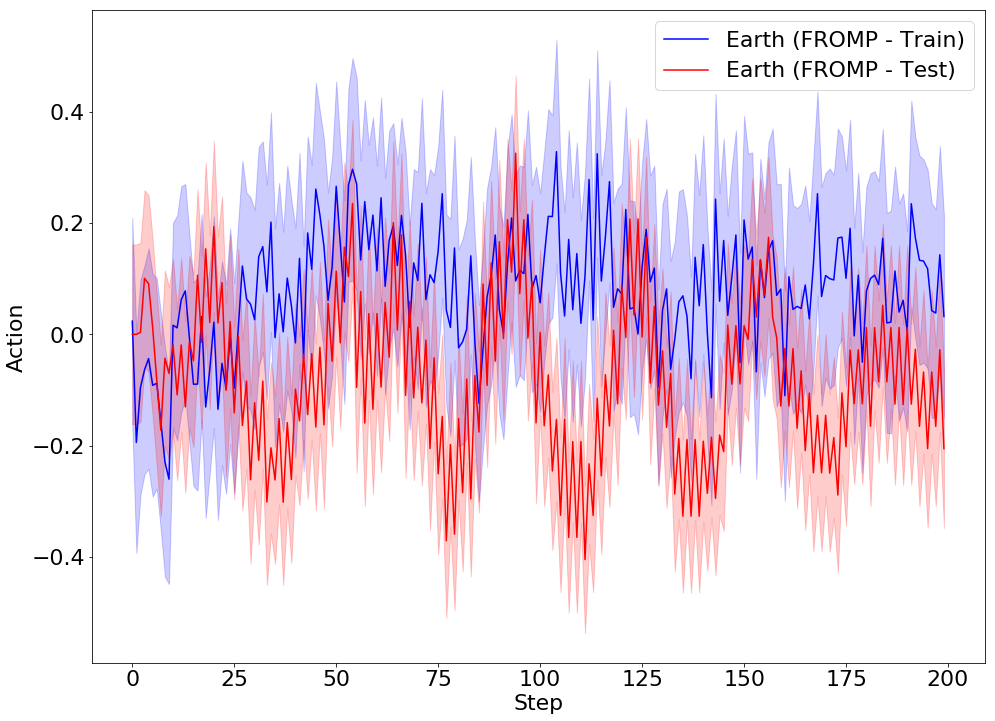

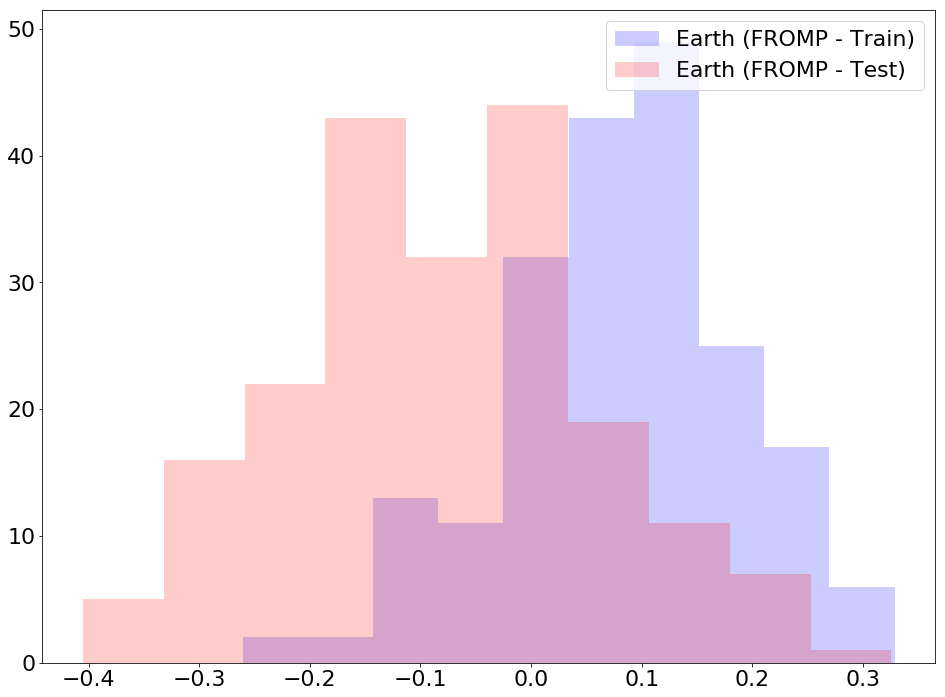

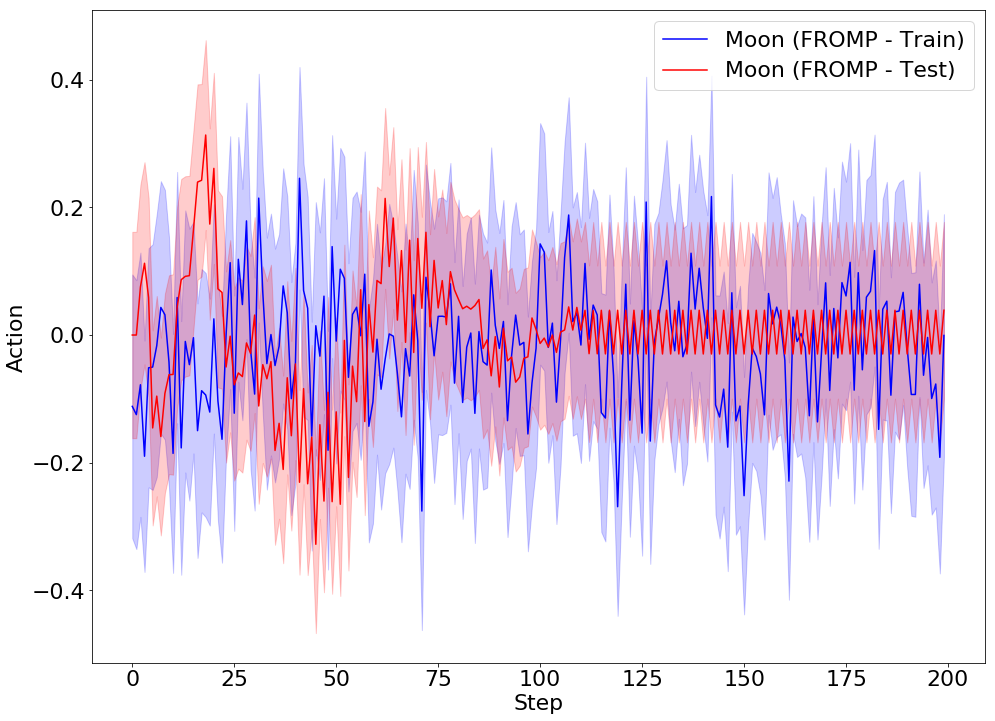

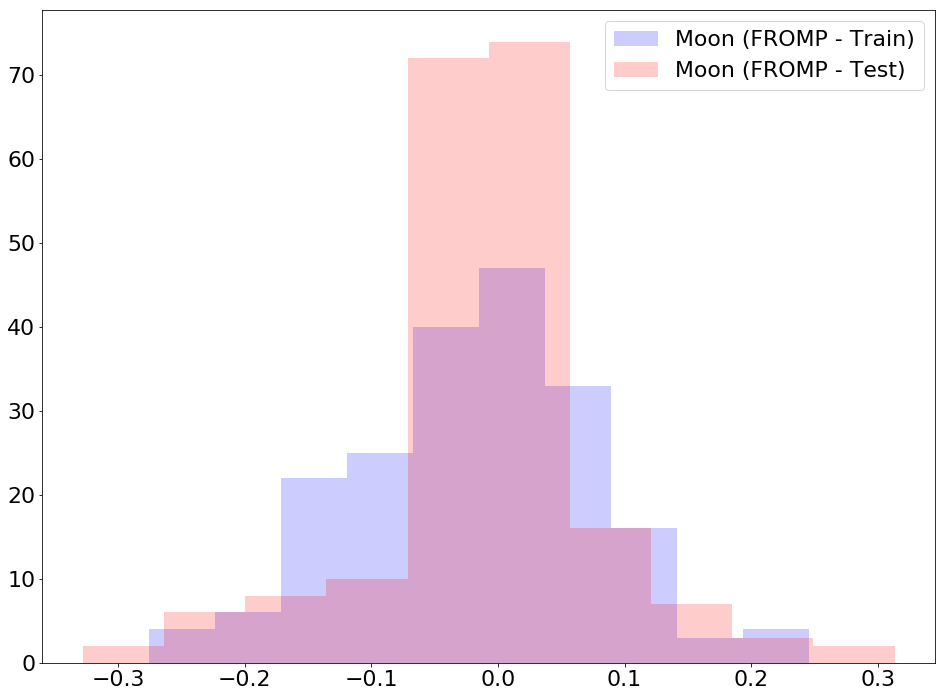

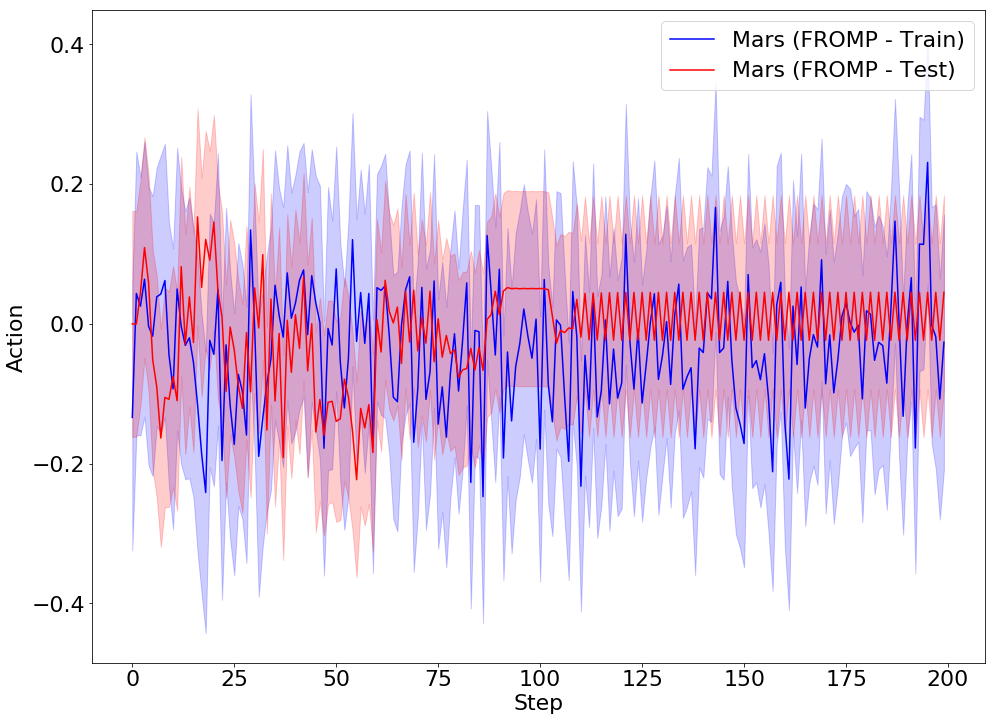

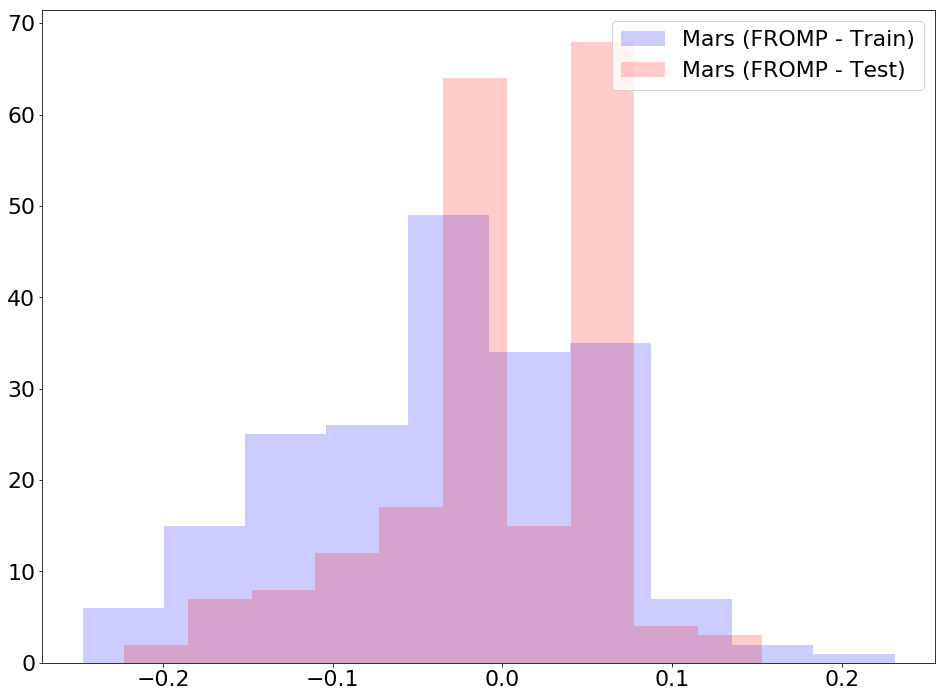

In [189]:
plot_actions(actions_earth, actions_earth_test, ['Earth (FROMP - Train)', 'Earth (FROMP - Test)'], n_tail = 200, col = ['blue', 'red'], 
             filename = "./Visualizations/trajectory_earth_test_fromp.jpg")
hist_actions(actions_earth, actions_earth_test, ['Earth (FROMP - Train)', 'Earth (FROMP - Test)'], n_tail = 200,
             filename = "./Visualizations/hist_earth_test_fromp.jpg")
plot_actions(actions_moon, actions_moon_test, ['Moon (FROMP - Train)', 'Moon (FROMP - Test)'], n_tail = 200, col = ['blue', 'red'], 
             filename = "./Visualizations/trajectory_moon_test_fromp.jpg")
hist_actions(actions_moon, actions_moon_test, ['Moon (FROMP - Train)', 'Moon (FROMP - Test)'], n_tail = 200, 
             filename = "./Visualizations/hist_moon_test_fromp.jpg")
plot_actions(actions_mars, actions_mars_test, ['Mars (FROMP - Train)', 'Mars (FROMP - Test)'], n_tail = 200, col = ['blue', 'red'], 
             filename = "./Visualizations/trajectory_mars_test_fromp.jpg")
hist_actions(actions_mars, actions_mars_test, ['Mars (FROMP - Train)', 'Mars (FROMP - Test)'], n_tail = 200,
             filename = "./Visualizations/hist_mars_test_fromp.jpg")

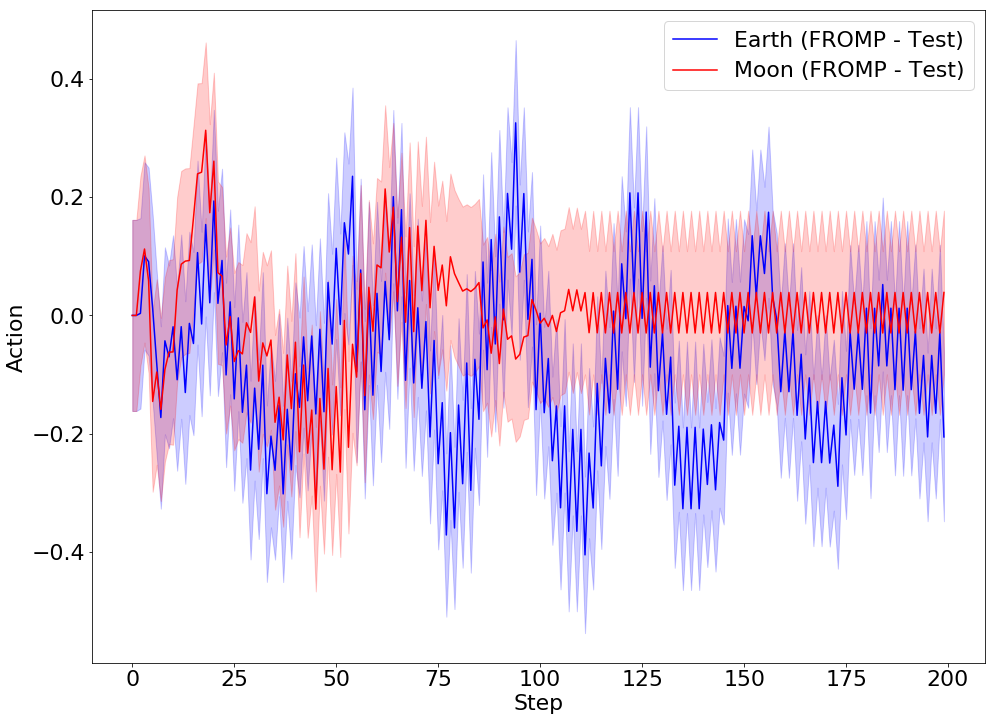

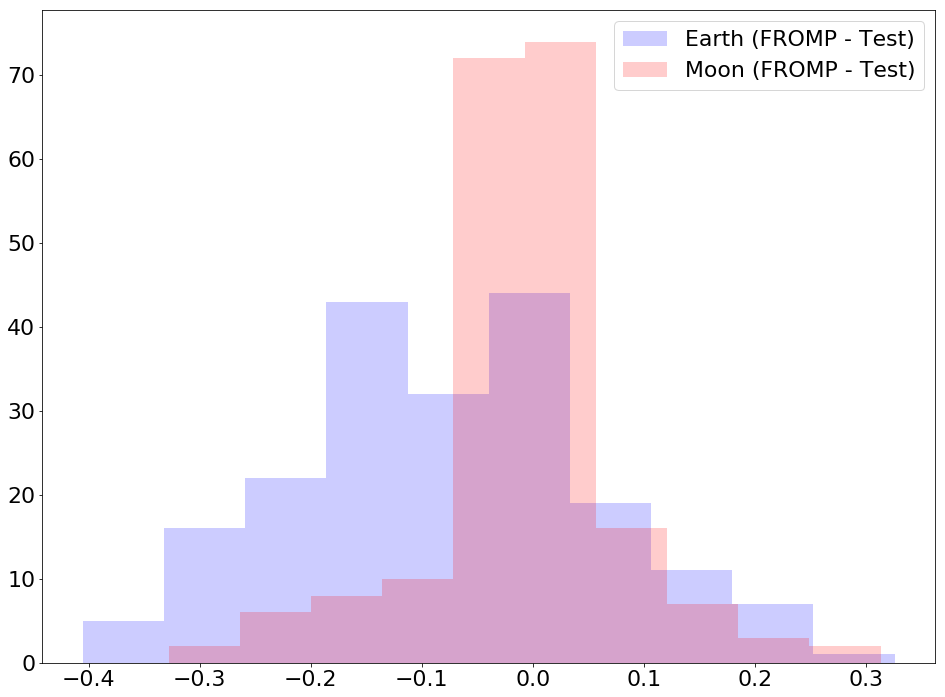

In [190]:
plot_actions(actions_earth_test, actions_moon_test, ['Earth (FROMP - Test)', 'Moon (FROMP - Test)'], n_tail = 200, col = ['blue', 'red'], 
             filename = "./Visualizations/trajectory_earth_moon_fromp.jpg")
hist_actions(actions_earth_test, actions_moon_test, ['Earth (FROMP - Test)', 'Moon (FROMP - Test)'], n_tail = 200,
             filename = "./Visualizations/hist_earth_moon_fromp.jpg")

/Users/kenneth01px2018/gym/gym/core.py:48: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


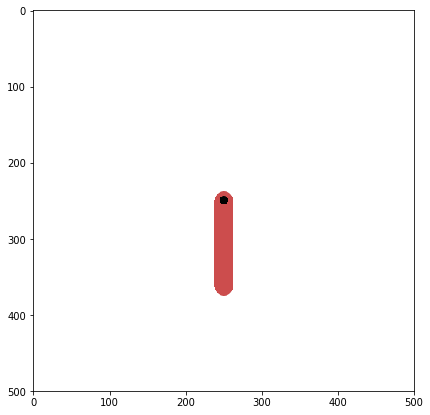

In [42]:
mars.reset()
mars.state[:]= math.pi, 0
env_screen = mars.render(mode = 'rgb_array')
mars.close()
plt.imshow(env_screen)

## Plot Memorable Points (Earth)

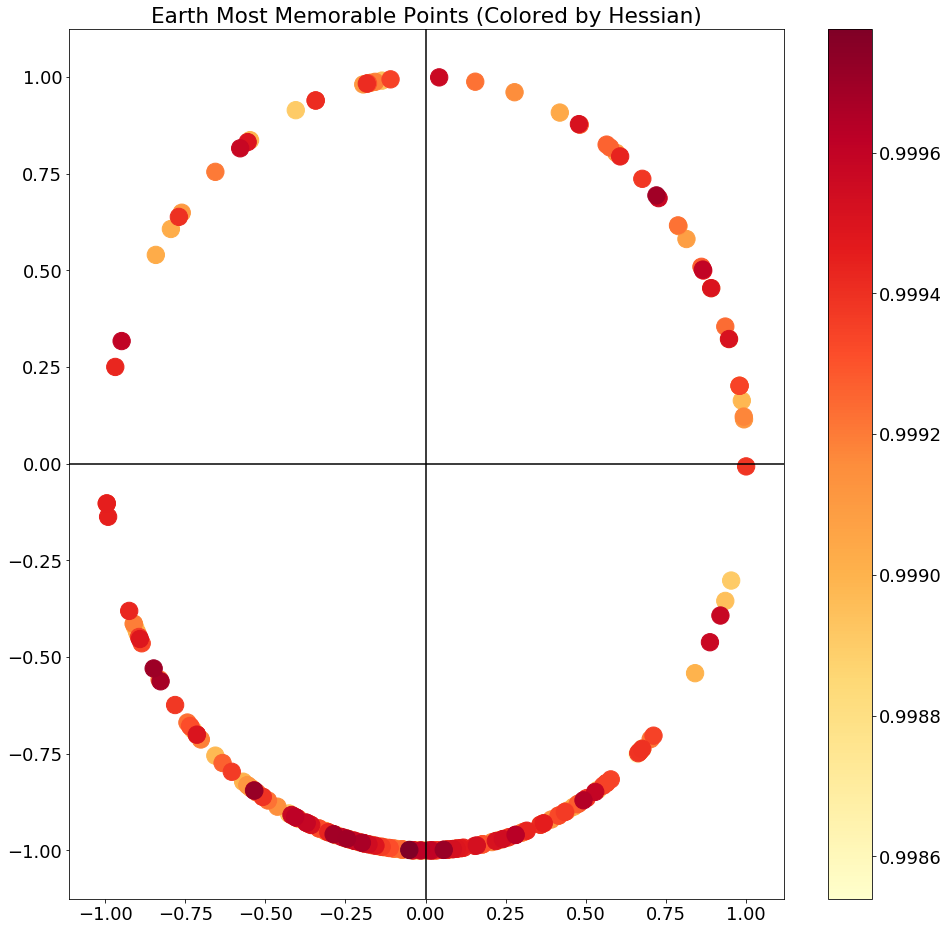

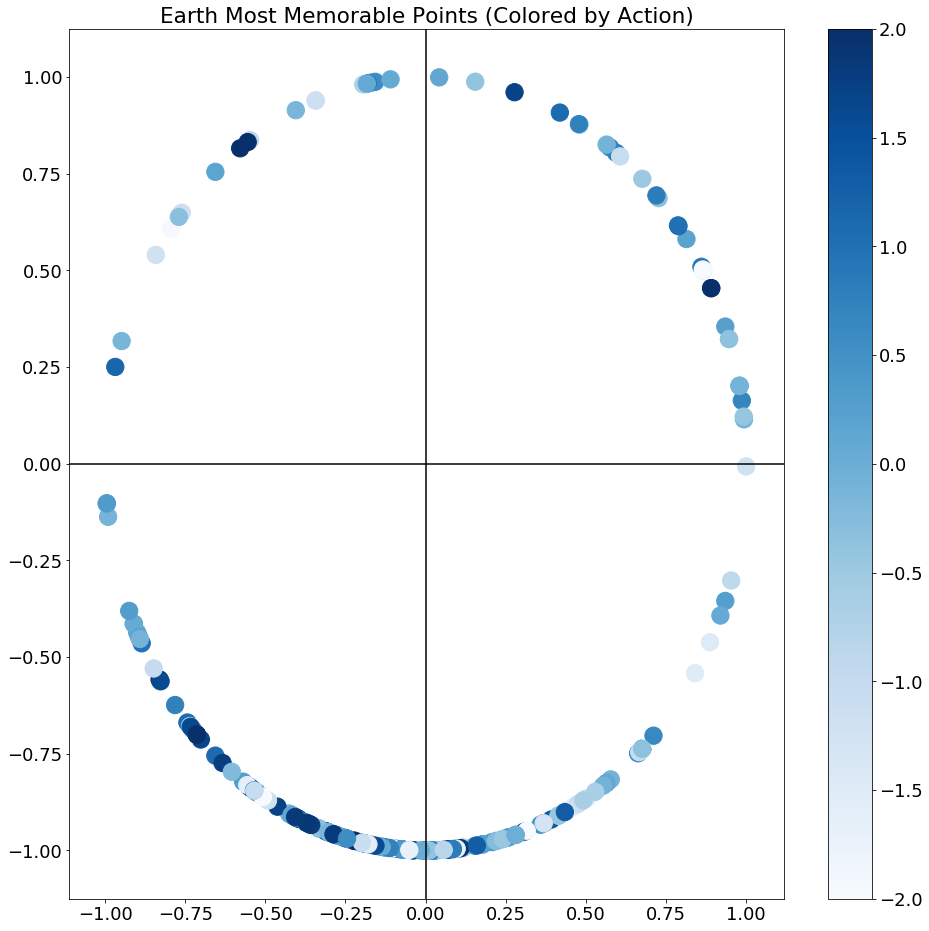

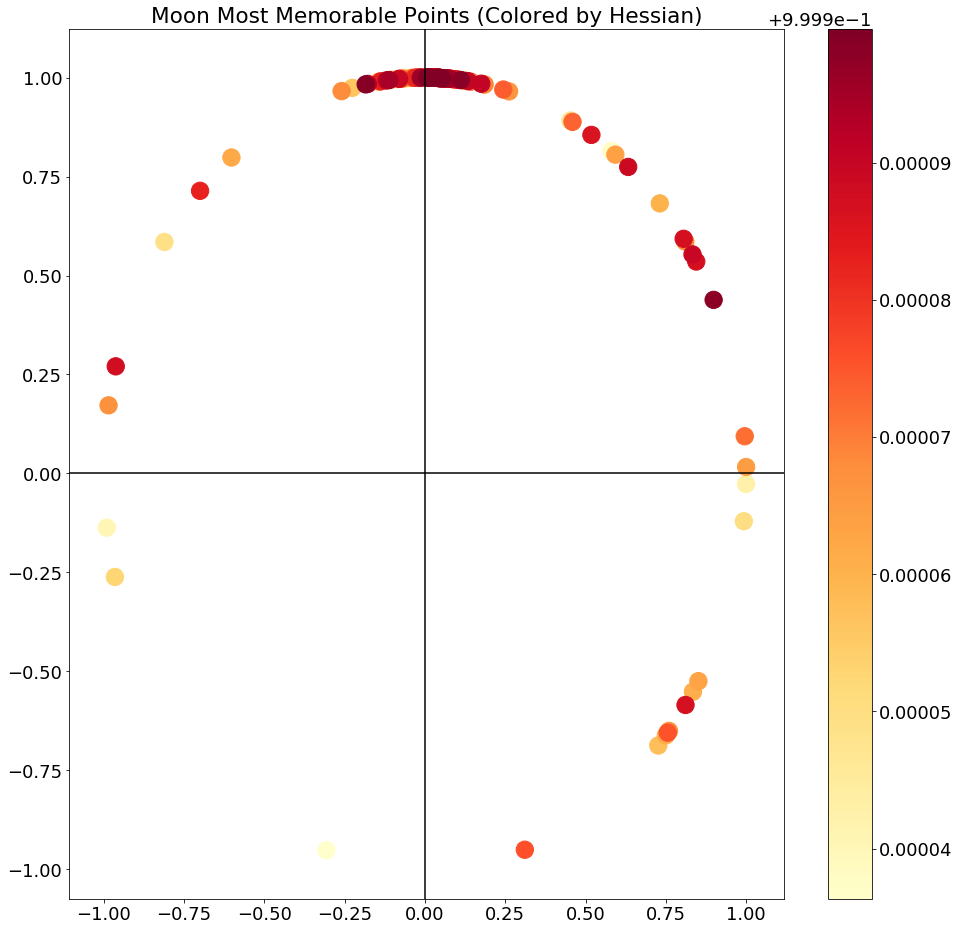

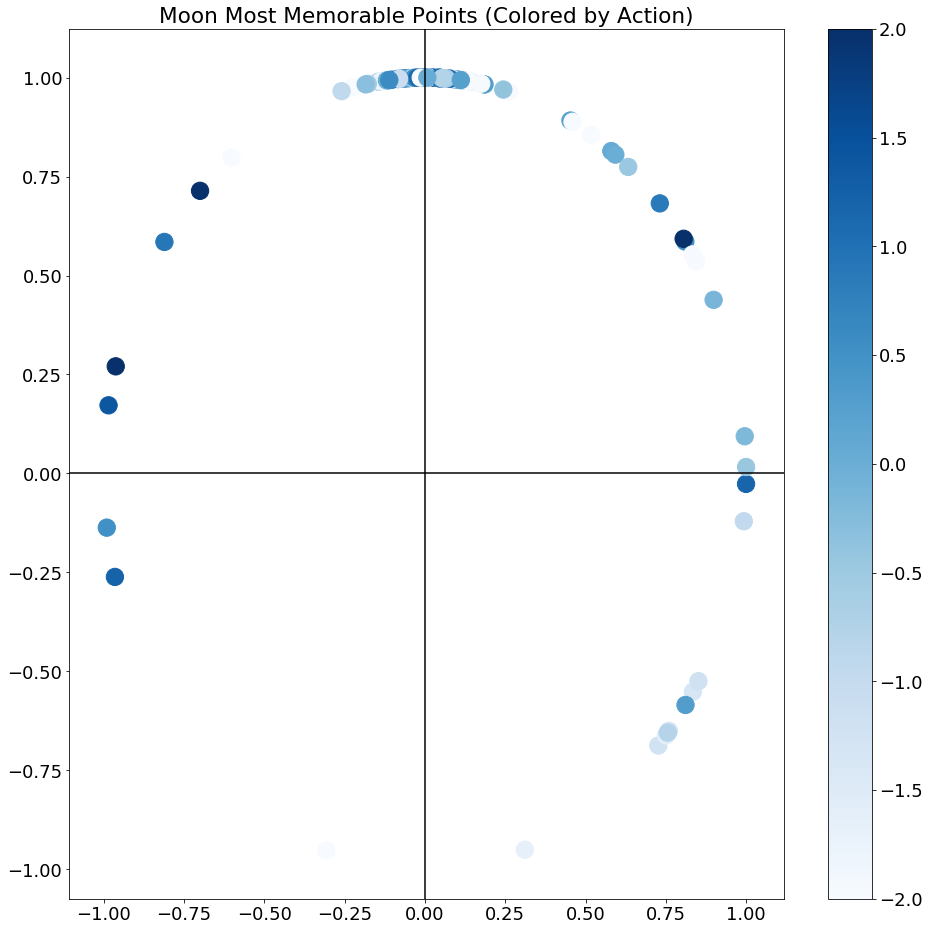

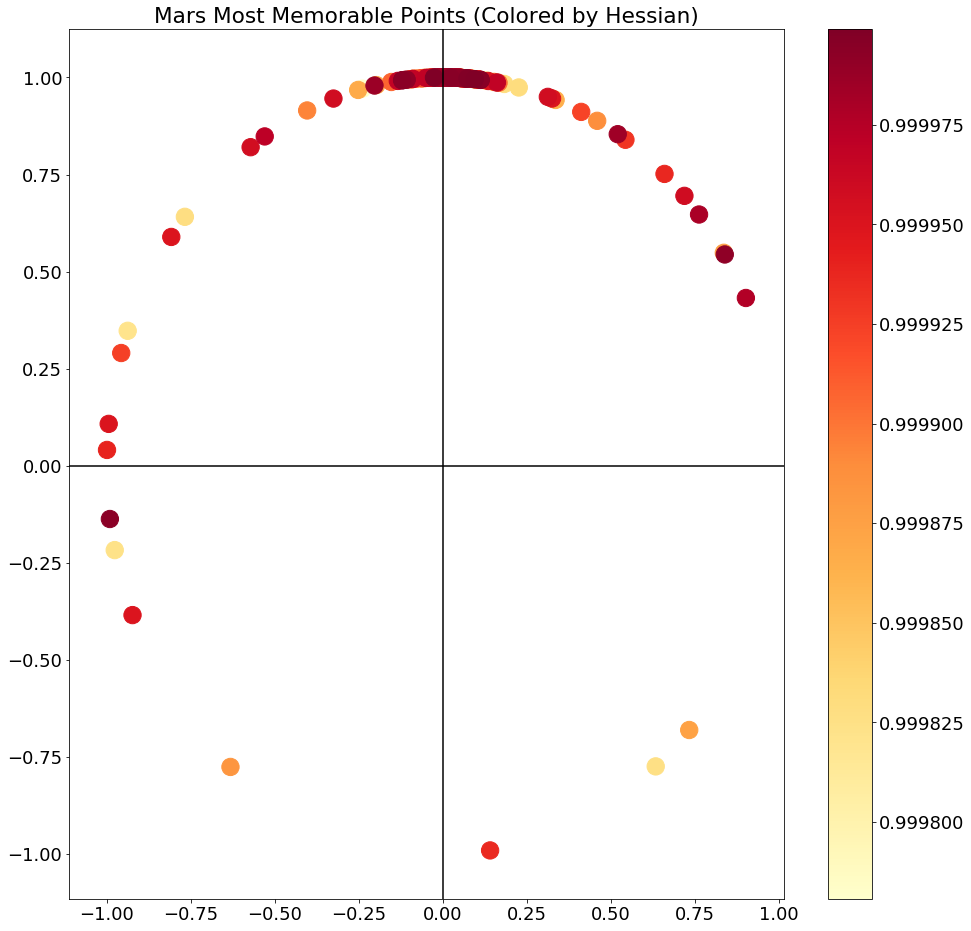

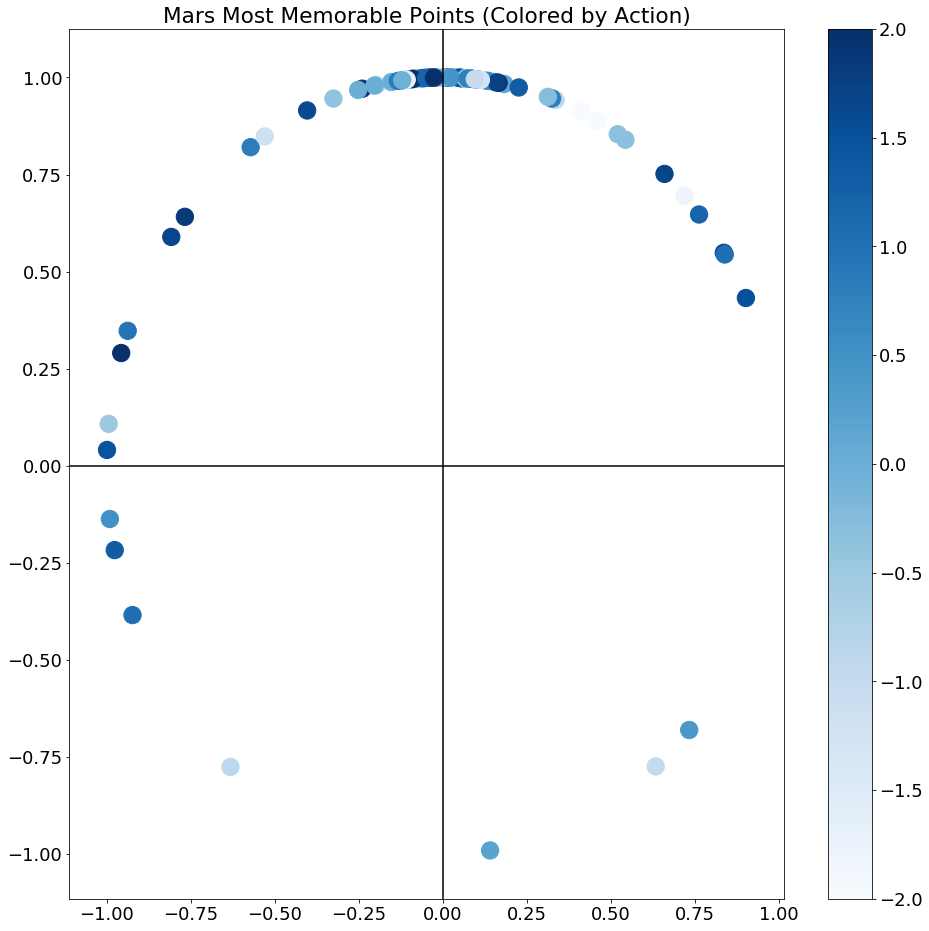

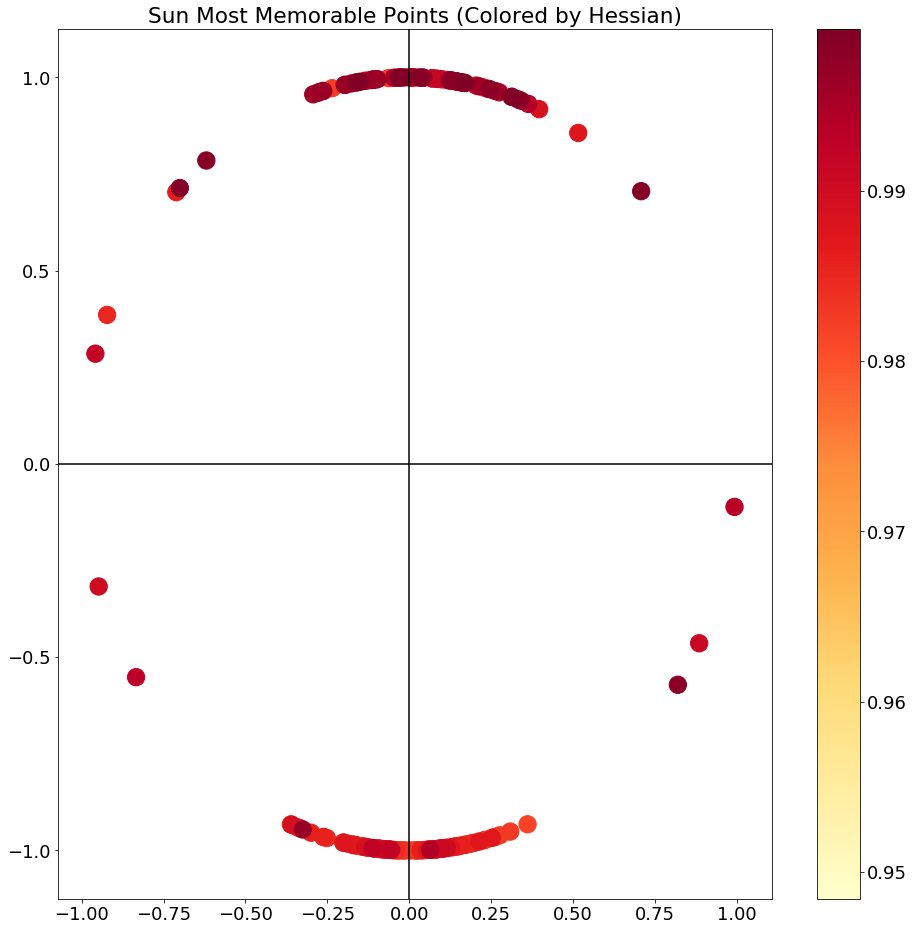

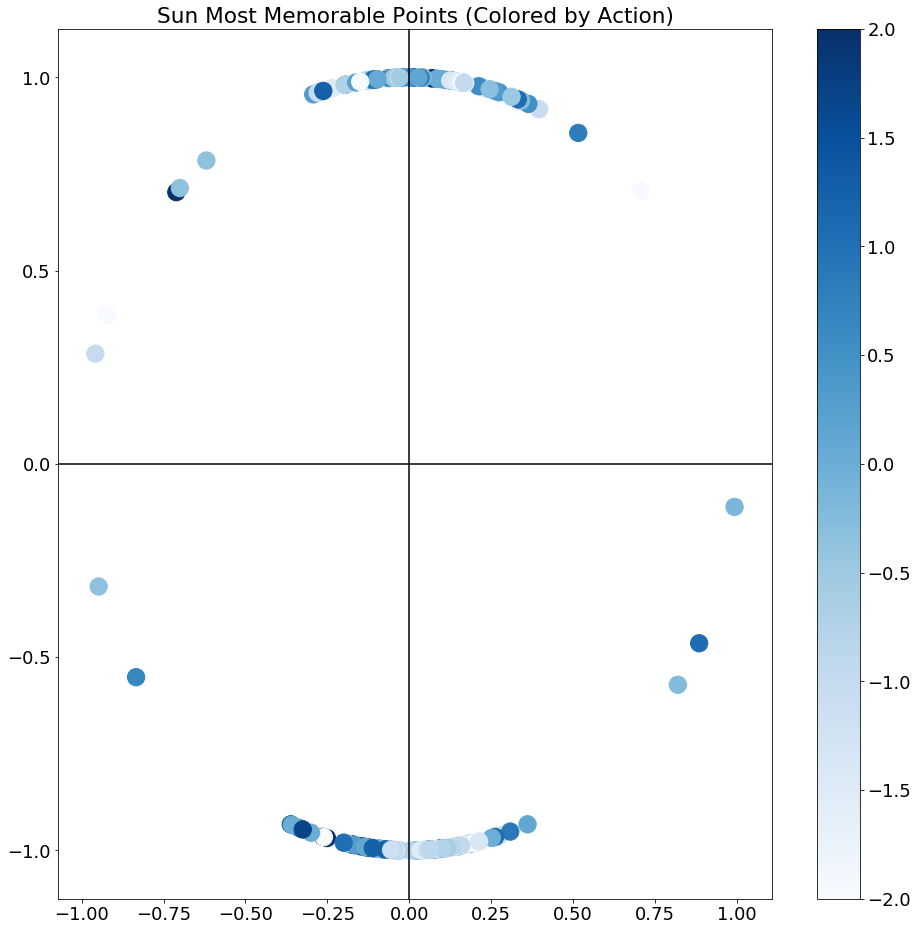

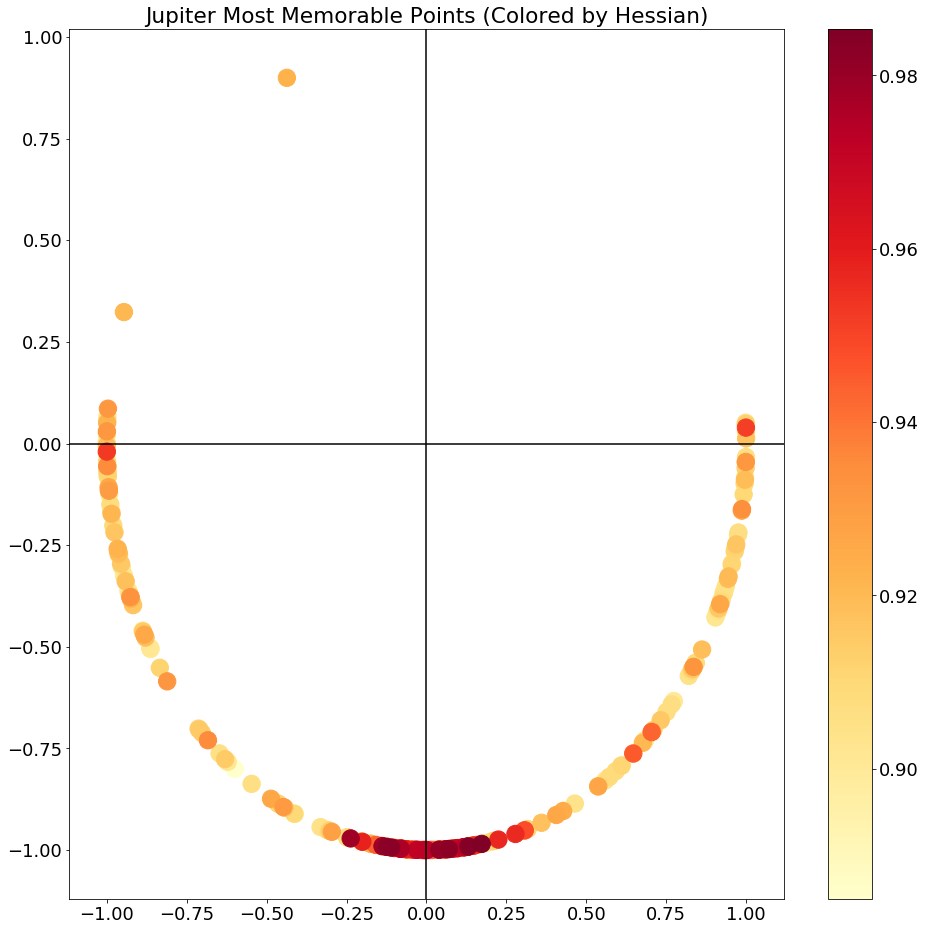

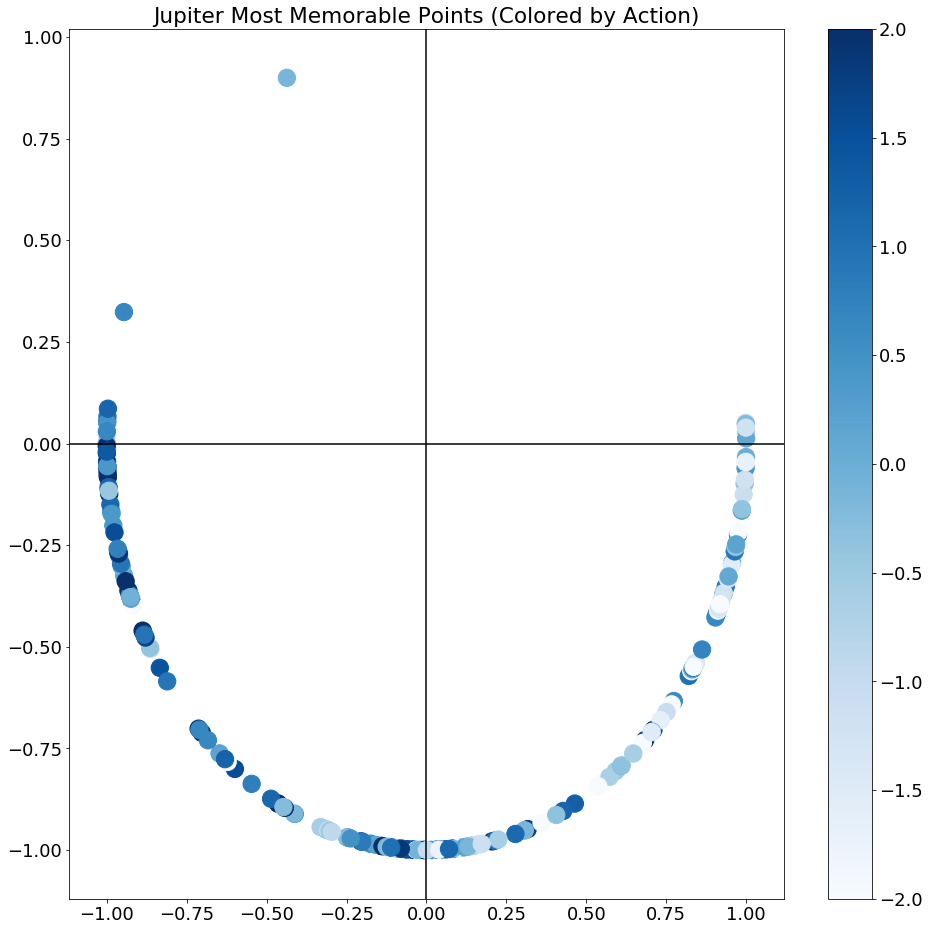

In [186]:
def plot_mem_pts(mem_pts, name = None, lbl = None, N = 100,
                 color = "hessian", cmap_color = "Wistia", filename = "./Visualizations/mem_pts.jpg"):
    mem_pts_dict = SortedDict(mem_pts)

    x_coords = [mem_pts_dict[key][0][0][1].item() for key in mem_pts_dict.keys()]
    y_coords = [mem_pts_dict[key][0][0][0].item() for key in mem_pts_dict.keys()]
    colors = [mem_pts_dict[key][1][0].item() for key in mem_pts_dict.keys()]
    hess_vals = [keys for keys in mem_pts_dict.keys()]
    mem_df = pd.DataFrame({'hessian': hess_vals, 'x': x_coords, 'y': y_coords, 'action': colors}).iloc[-N:]

    plt.scatter(mem_df['x'], mem_df['y'], s = 300, c = mem_df[color], cmap = plt.get_cmap(cmap_color))
    if lbl is not None:
        plt.colorbar(label = lbl)
    else:
        plt.colorbar()
    if name is not None:
        plt.title(name)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    fig = plt.gcf()
    fig.set_size_inches(16, 16)
    plt.savefig(filename)
    plt.show()
    
    
plot_mem_pts(mem_pts[1], 
             name = "Earth Most Memorable Points (Colored by Hessian)", 
             cmap_color = "YlOrRd",  N = 256,
             filename = "./Visualizations/earth_hes_mem_pts.jpg",
            )
plot_mem_pts(mem_pts[1], 
             name = "Earth Most Memorable Points (Colored by Action)", 
             color = "action",
             cmap_color = "Blues",  N = 256,
             filename = "./Visualizations/earth_action_mem_pts.jpg",
            )
plot_mem_pts(mem_pts[2], 
             name = "Moon Most Memorable Points (Colored by Hessian)", 
             cmap_color = "YlOrRd", N = 256,
             filename = "./Visualizations/moon_hes_mem_pts.jpg",
            )
plot_mem_pts(mem_pts[2], 
             name = "Moon Most Memorable Points (Colored by Action)", 
             color = "action",
             cmap_color = "Blues", N = 256,
             filename = "./Visualizations/moon_action_mem_pts.jpg",
            )
plot_mem_pts(mem_pts[3], 
             name = "Mars Most Memorable Points (Colored by Hessian)", 
             cmap_color = "YlOrRd", N = 256,
             filename = "./Visualizations/mars_hes_mem_pts.jpg",
            )
plot_mem_pts(mem_pts[3], 
             name = "Mars Most Memorable Points (Colored by Action)", 
             color = "action",
             cmap_color = "Blues", N = 256,
             filename = "./Visualizations/mars_action_mem_pts.jpg",
            )
plot_mem_pts(mem_pts[4], 
             name = "Sun Most Memorable Points (Colored by Hessian)", 
             cmap_color = "YlOrRd",  N = 256,
             filename = "./Visualizations/sun_hes_mem_pts.jpg",
            )
plot_mem_pts(mem_pts[4], 
             name = "Sun Most Memorable Points (Colored by Action)", 
             color = "action",
             cmap_color = "Blues",  N = 256,
             filename = "./Visualizations/sun_action_mem_pts.jpg",
            )
plot_mem_pts(mem_pts[5], 
             name = "Jupiter Most Memorable Points (Colored by Hessian)", 
             cmap_color = "YlOrRd",  N = 256,
             filename = "./Visualizations/jupiter_hes_mem_pts.jpg",
            )
plot_mem_pts(mem_pts[5], 
             name = "Jupiter Most Memorable Points (Colored by Action)", 
             color = "action",
             cmap_color = "Blues",  N = 256,
             filename = "./Visualizations/jupiter_action_mem_pts.jpg",
            )

## Plot Loss Functions
For presentations

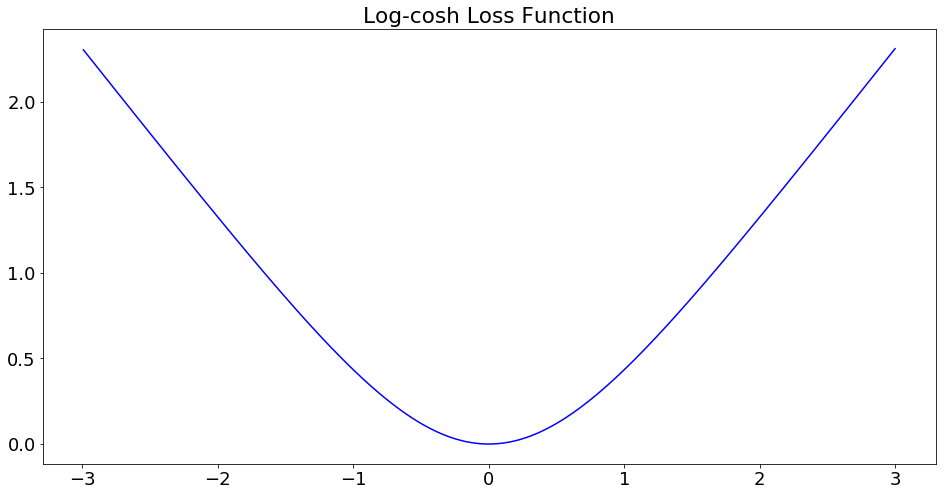

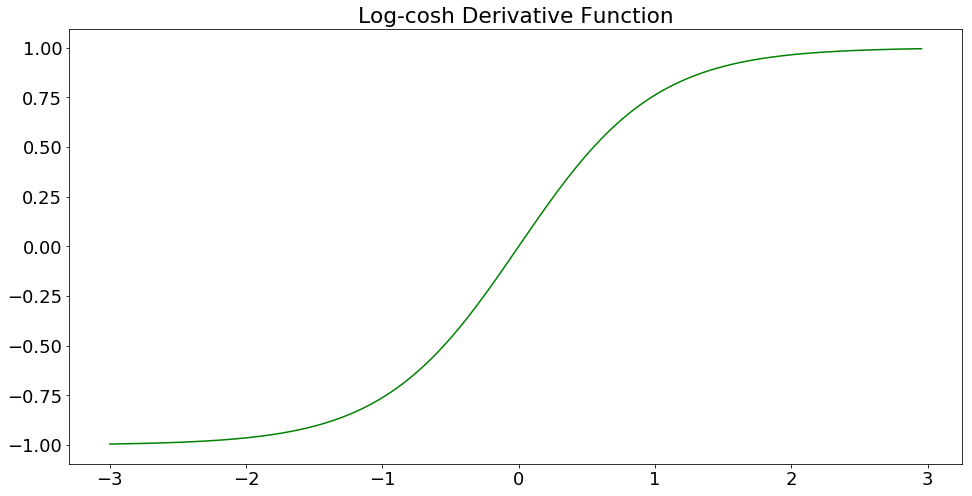

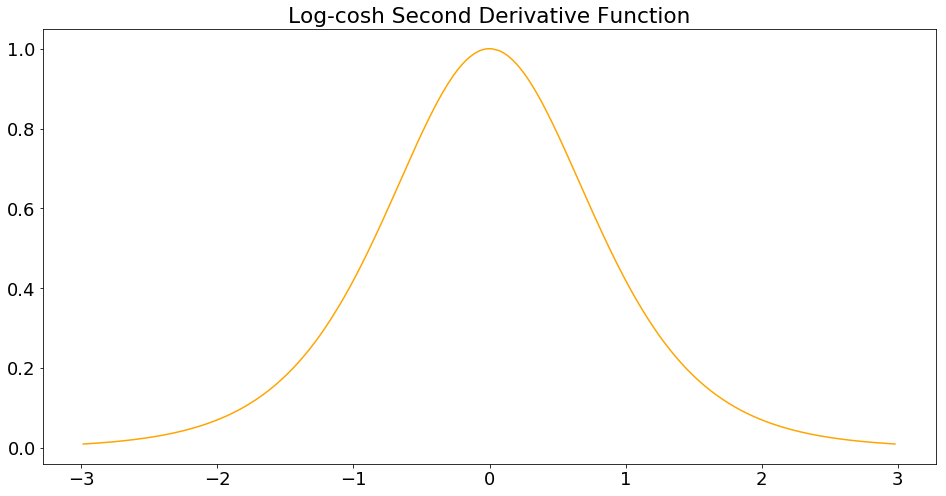

In [180]:
x_vals = np.sort(np.random.uniform(-3, 3, 1000))
y_vals = np.log(np.cosh(x_vals))
plt.plot(x_vals, y_vals, color = 'blue')
plt.title("Log-cosh Loss Function")
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.savefig("./Visualizations/logcosh_plot.jpg")
plt.show()
x_vals = np.sort(np.random.uniform(-3, 3, 1000))
y_vals = np.tanh(x_vals)
plt.plot(x_vals, y_vals, color = 'green')
plt.title("Log-cosh Derivative Function")
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.savefig("./Visualizations/tanh_plot.jpg")
plt.show()
x_vals = np.sort(np.random.uniform(-3, 3, 1000))
y_vals = 1 / np.cosh(x_vals)**2
plt.plot(x_vals, y_vals, color = 'orange')
plt.title("Log-cosh Second Derivative Function")
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.savefig("./Visualizations/sech_plot.jpg")
plt.show()

In [64]:
df = pd.read_csv('./Data/test_rewards_pendulum_fromp_OHE.csv')
df.mean()

Unnamed: 0      24.500000
earth         -645.805475
moon           -57.136458
mars          -141.570502
sun          -2092.440027
jupiter      -1427.457225
dtype: float64

In [65]:
print(test_df_fromp.mean())

earth      -469.182698
moon        -73.056251
mars        -77.704843
sun       -2338.883436
jupiter   -1430.244914
dtype: float64


In [181]:
max_hes = 0
min_hes = np.Inf
for i in [1, 2, 3]:
    for j in mem_pts[i].keys():
        if j > max_hes:
            max_hes = j
        if j < min_hes:
            min_hes = j
print(max_hes, min_hes)

0.9999997615814209 0.9985396862030029


## Visualize Results

In [63]:
# earth = NormalizedActions(gym.make('Pendulum-v1', g = 9.81, render_mode = 'human'))
# earth.reset(seed = 24)
# for _ in range(10):
#     r = 0
#     state = earth.reset()
#     earth.state[:]= math.pi/8, 0
#     state = [np.cos(math.pi/8), np.sin(math.pi/8), 0.0]
#     for t in range(max_steps):
#         action = policy_net_fromp.get_action(state)
#         next_state, reward, done, _ = earth.step(action)   
#         state = next_state 
#         r += reward
#         if done:
#             print(r)
#             break
#         earth.render(mode = "human")
#         time.sleep(0.001)
# print('Complete')
# earth.close()

In [149]:
# for _ in range(5):
#     state = moon.reset()
#     state = np.concatenate((state, moon_OHE))
#     for t in range(max_steps):
#         action = policy_net.get_action(state)
#         next_state, reward, done, _ = moon.step(action)   
#         next_state = np.concatenate((next_state, moon_OHE))
#         state = next_state       
#         if done:
#             break
#         moon.render(mode = "human")
#         time.sleep(0.001)
# print('Complete')
# moon.close()

In [150]:
# for _ in range(5):
#     state = mars.reset()
#     for t in range(max_steps):
#         action = policy_net.get_action(state)
#         next_state, reward, done, _ = mars.step(action)   
#         state = next_state       
#         if done:
#             break
#         mars.render(mode = "human")
#         time.sleep(0.001)
# print('Complete')
# mars.close()